# Coronawiki dataset exploration

The purpose of the following notebook is to get familiar with the given Coronawiki data, as it is split among multiple files which serve different purposes.

As such, we will attempt to do the following tasks in this notebook:

- Preprocessing of the data,to make it more comfortable to use (Split the dataframes, give them another format, etc)
- Data wrangling: a lot of the data are timeseries which could be put together to derive interesting results
- First analysis phase

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Timeseries <a id='timeseries'></a>

The most important data we have in this dataset are time series of the Wikipedia views from 2018 to July 2020 for 14 different languages: one part are the total views for all of that language's wikipedia, a second part are the views for the articles that are related to Covid-19, as well as the percentage. Finally, we also have for the same window of time the views for different topics.

In [2]:
timeseries = pd.read_json("Data/aggregated_timeseries.json.gz")
timeseries.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,...,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,"{'2018-01-01 00:00:00': 22328288, '2018-01-02 ...","{'2018-01-01 00:00:00': 3338750, '2018-01-02 0...","{'2018-01-01 00:00:00': 765123, '2018-01-02 00...","{'2018-01-01 00:00:00': 407629, '2018-01-02 00...","{'2018-01-01 00:00:00': 715031, '2018-01-02 00...","{'2018-01-01 00:00:00': 86763830, '2018-01-02 ...","{'2018-01-01 00:00:00': 192409, '2018-01-02 00...","{'2018-01-01 00:00:00': 493684, '2018-01-02 00...","{'2018-01-01 00:00:00': 135822131, '2018-01-02...","{'2018-01-01 00:00:00': 224417, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 1484496, '2018-01-02 0...","{'2018-01-01 00:00:00': 1319053, '2018-01-02 0...","{'2018-01-01 00:00:00': 451383, '2018-01-02 00...","{'2018-01-01 00:00:00': 7828155, '2018-01-02 0...","{'2018-01-01 00:00:00': 6441009, '2018-01-02 0...","{'2018-01-01 00:00:00': 523135, '2018-01-02 00...","{'2018-01-01 00:00:00': 111910, '2018-01-02 00...","{'2018-01-01 00:00:00': 12856884, '2018-01-02 ...","{'2018-01-01 00:00:00': 2383474, '2018-01-02 0...","{'2018-01-01 00:00:00': 819174, '2018-01-02 00..."
covid,"{'len': 30, 'sum': {'2018-01-01 00:00:00': 55,...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 50,...","{'len': 4, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 1, ...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 7, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 57...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 6, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 3, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 91...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 2, ...",...,"{'len': 113, 'sum': {'2018-01-01 00:00:00': 6,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 11, ...","{'len': 30, 'sum': {'2018-01-01 00:00:00': 26,...","{'len': 16, 'sum': {'2018-01-01 00:00:00': 62,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 2, '...","{'len': 49, 'sum': {'2018-01-01 00:00:00': 6, ...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 139...","{'len': 8, 'sum': {'2018-01-01 00:00:00': 19, ...","{'len': 113, 'sum': {'2018-01-01 00:00:00': 3,..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Culture.Biography.Biography*': {'len': 37580...,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 38258...,{'Culture.Biography.Biography*': {'len': 10444...,{'Culture.Biography.Biography*': {'len': 10175...,{'Culture.Biography.Biography*': {'len': 29422...,{'Culture.Biography.Biography*': {'len': 14668...,{'Culture.Biography.Biography*': {'len': 75498...


In [3]:
timeseries.columns

Index(['ja.m', 'it', 'da.m', 'tr', 'no.m', 'en', 'sr', 'tr.m', 'en.m', 'no',
       'sv', 'nl.m', 'nl', 'da', 'de', 'fr.m', 'ca.m', 'de.m', 'ko.m', 'fi.m',
       'sr.m', 'ja', 'fr', 'fi', 'ca', 'it.m', 'sv.m', 'ko'],
      dtype='object')

In [4]:
languages_unique = timeseries.columns.map(lambda x: x[:2]).unique()

Correspondence:
- ja -> Japanese
- it -> Italian
- da -> Danish
- tr -> Turkish
- no -> Norwegian
- en -> English
- sr -> Serbian
- sv -> Swedish
- nl -> Dutch
- de -> German
- fr -> French
- ca -> Catalan
- ko -> Korean
- fi -> Finnish

### Splitting the timeseries data into different dataframes

As we can see, the data's format isn't ideal: for each language, the data is split into 3 Python dictionaries corresponding to the data described above, and it would be nice to separate these pieces of data to be able to read directly for each date, for example, the total number of views accross all languages, instead of having to iterate over each language's dictionnary every time.

This will also make the analysis phase easier later on.

### Total sum of views, views of articles related to Covid

<a id='extraction_format'></a>
In this part of the code we extract two following kind of data, for each date:
- For every language's Wikipedia, the total number of views on that particular date
- For every language's Wikipedia, the total number of views for articles related to Covid-19 on that particular date

---


Every resulting dataframe will have the following format:

 Column name          | Description                                                                                                                                                                                       |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| date           | A particular date between January 2018 (inclusive) and July of 2020 (inclusive)                                                                                                                                             |
| language       | The corresponding wikipedia language                                                                |
 |   |   |
| views  | The number of views (total or only for articles related to Covid-19) for this language and date



---



We also extract another dataframe that simply maps for each language the number of articles that were considered in the original experiment. Finally, a last dataframe which is redundant with the two first ones is present: one which gives for each day the percentage of views that went to Covid related articles.

In [5]:
timeseries_total_sum_dict = {}
timeseries_covid_len_dict = {}
timeseries_covid_sum_dict = {}
timeseries_covid_percent_dict = {}
for cn in timeseries.columns:
    timeseries_total_sum_dict[cn] = timeseries[cn]["sum"]
    timeseries_covid_len_dict[cn] = timeseries[cn]["covid"]["len"]
    timeseries_covid_sum_dict[cn] = timeseries[cn]["covid"]["sum"]
    timeseries_covid_percent_dict[cn] = timeseries[cn]["covid"]["percent"]

In [6]:
sum_data_df = pd.DataFrame.from_dict(timeseries_total_sum_dict, orient="index").T
covid_len_data_df = pd.DataFrame.from_dict(
    timeseries_covid_len_dict, orient="index", columns=["len"]
).T
covid_sum_data_df = pd.DataFrame.from_dict(timeseries_covid_sum_dict, orient="index").T
covid_percent_data_df = pd.DataFrame.from_dict(
    timeseries_covid_percent_dict, orient="index"
).T

In [7]:
# Fuse the .m and the normal columns together, and separate the data
new_sum_data_df = pd.DataFrame()
new_covid_sum_data_df = pd.DataFrame()
for language in languages_unique:
    country_sum_data = pd.DataFrame()
    country_sum_data["views"] = sum_data_df[language] + sum_data_df[language + ".m"]
    country_sum_data["language"] = language
    new_sum_data_df = pd.concat([new_sum_data_df, country_sum_data], axis=0)

    country_covid_sum_data = pd.DataFrame()
    country_covid_sum_data["views"] = (
        covid_sum_data_df[language] + covid_sum_data_df[language + ".m"]
    )
    country_covid_sum_data["language"] = language
    new_covid_sum_data_df = pd.concat(
        [new_covid_sum_data_df, country_covid_sum_data], axis=0
    )

sum_data_df = new_sum_data_df
covid_sum_data_df = new_covid_sum_data_df

In [8]:
sum_data_df.head()

,views,language
2018-01-01 00:00:00,30156443,ja
2018-01-02 00:00:00,31038338,ja
2018-01-03 00:00:00,33628914,ja
2018-01-04 00:00:00,33870576,ja
2018-01-05 00:00:00,33481670,ja


In [9]:
sum_data_df.index = covid_sum_data_df.index = pd.to_datetime(sum_data_df.index)
covid_percent_data_df.index = pd.to_datetime(covid_percent_data_df.index)
sum_data_df["date"] = covid_sum_data_df["date"] = sum_data_df.index
covid_percent_data_df["date"] = covid_percent_data_df.index
# covid_sum_data_df = covid_sum_data_df[new_column_order]
# covid_percent_data_df = covid_percent_data_df[new_column_order]

In [10]:
sum_data_df.head()

,views,language,date
2018-01-01,30156443,ja,2018-01-01
2018-01-02,31038338,ja,2018-01-02
2018-01-03,33628914,ja,2018-01-03
2018-01-04,33870576,ja,2018-01-04
2018-01-05,33481670,ja,2018-01-05


In [11]:
covid_sum_data_df.head()

,views,language,date
2018-01-01,81,ja,2018-01-01
2018-01-02,97,ja,2018-01-02
2018-01-03,104,ja,2018-01-03
2018-01-04,160,ja,2018-01-04
2018-01-05,204,ja,2018-01-05


In [12]:
covid_percent_data_df.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko,date
2018-01-01,0.000002,0.000015,0.000000,0.000002,0.000010,0.000007,0.000031,0.000006,0.000007,0.000009,...,0.000000,0.000024,0.000003,0.000010,0.000004,0.000054,0.000011,0.000008,0.000004,2018-01-01
2018-01-02,0.000002,0.000019,0.000005,0.000007,0.000009,0.000010,0.000051,0.000004,0.000008,0.000011,...,0.000000,0.000043,0.000005,0.000010,0.000003,0.000030,0.000015,0.000006,0.000021,2018-01-02
2018-01-03,0.000002,0.000023,0.000002,0.000013,0.000004,0.000010,0.000040,0.000004,0.000008,0.000007,...,0.000008,0.000037,0.000005,0.000011,0.000003,0.000048,0.000013,0.000007,0.000019,2018-01-03
2018-01-04,0.000002,0.000019,0.000000,0.000002,0.000004,0.000010,0.000022,0.000019,0.000009,0.000002,...,0.000000,0.000077,0.000010,0.000011,0.000005,0.000049,0.000015,0.000008,0.000017,2018-01-04
2018-01-05,0.000003,0.000022,0.000000,0.000000,0.000003,0.000010,0.000051,0.000004,0.000008,0.000009,...,0.000000,0.000087,0.000011,0.000012,0.000000,0.000024,0.000010,0.000005,0.000021,2018-01-05


### Checking for missing data

Before continuing further, let us check for missing data in the timeseries; this will help us avoid bad surprises later on.

In [13]:
sum_data_df.isnull().any().any(), covid_sum_data_df.isnull().any().any(), covid_percent_data_df.isnull().any().any()

(False, False, True)

There appears to be some missing data in the percentage dataframe; let's check by language where that missing data is reported.

In [14]:
missing_data_language = covid_percent_data_df.isnull().any(axis=0)
missing_data_language[missing_data_language]

sv    True
dtype: bool

Looking at the paper, this corresponds to Swedish.

In [15]:
# Decomment Run this cell if you want to see how the missing data can be seen in the original timeseries
# timeseries.loc[:,'sv']['sum']

It appears that, for desktop devices, the views for the Swedish Wikipedia haven't been collected for the whole year 2018. The reason for that is unknown, as a quick search tells us that this version has existed since 2001. The mobile data, however, is available. We will need to take this into account when doing our analysis in the future, for example by not taking into account 2018.

### Topics data

Now we will extract for each language, all the views per topic in such a way that the data becomes more usable. In the original data, all topic-related information was in a single dictionnary; we're gonna separate them in a way that each column will correspond to a different topic, with each row being a different language.

In [16]:
country_to_topics = {}
for cn in timeseries.columns:
    country_to_topics[cn] = timeseries[cn]["topics"]
topics_df = pd.DataFrame.from_dict(country_to_topics, orient="index")

In [17]:
countries_to_topics_len = {}
countries_to_topics_sum = {}
countries_to_topics_percent = {}
for country in topics_df.index:
    countries_to_topics_len[country] = {}
    countries_to_topics_sum[country] = {}
    countries_to_topics_percent[country] = {}
    for topic in topics_df.columns:
        countries_to_topics_len[country][topic] = topics_df.loc[country, topic]["len"]
        countries_to_topics_sum[country][topic] = topics_df.loc[country, topic]["sum"]
        countries_to_topics_percent[country][topic] = topics_df.loc[country, topic][
            "percent"
        ]
countries_to_topics_len_df = pd.DataFrame.from_dict(
    countries_to_topics_len, orient="index"
)
countries_to_topics_sum_df = pd.DataFrame.from_dict(
    countries_to_topics_sum, orient="index"
)
countries_to_topics_percent_df = pd.DataFrame.from_dict(
    countries_to_topics_percent, orient="index"
)

In [18]:
countries_to_topics_sum_df.head()

,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,Culture.Media.Media*,...,STEM.Computing,STEM.Earth and environment,STEM.Engineering,STEM.Libraries & Information,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology
ja.m,"{'2018-01-01 00:00:00': 6629234, '2018-01-02 0...","{'2018-01-01 00:00:00': 1462146, '2018-01-02 0...","{'2018-01-01 00:00:00': 302934, '2018-01-02 00...","{'2018-01-01 00:00:00': 443986, '2018-01-02 00...","{'2018-01-01 00:00:00': 109480, '2018-01-02 00...","{'2018-01-01 00:00:00': 2140880, '2018-01-02 0...","{'2018-01-01 00:00:00': 97435, '2018-01-02 00:...","{'2018-01-01 00:00:00': 238059, '2018-01-02 00...","{'2018-01-01 00:00:00': 681533, '2018-01-02 00...","{'2018-01-01 00:00:00': 4264889, '2018-01-02 0...",...,"{'2018-01-01 00:00:00': 91338, '2018-01-02 00:...","{'2018-01-01 00:00:00': 72493, '2018-01-02 00:...","{'2018-01-01 00:00:00': 316615, '2018-01-02 00...","{'2018-01-01 00:00:00': 10072, '2018-01-02 00:...","{'2018-01-01 00:00:00': 44902, '2018-01-02 00:...","{'2018-01-01 00:00:00': 485801, '2018-01-02 00...","{'2018-01-01 00:00:00': 76863, '2018-01-02 00:...","{'2018-01-01 00:00:00': 1793359, '2018-01-02 0...","{'2018-01-01 00:00:00': 64445, '2018-01-02 00:...","{'2018-01-01 00:00:00': 264636, '2018-01-02 00..."
it,"{'2018-01-01 00:00:00': 809879, '2018-01-02 00...","{'2018-01-01 00:00:00': 193009, '2018-01-02 00...","{'2018-01-01 00:00:00': 34632, '2018-01-02 00:...","{'2018-01-01 00:00:00': 66037, '2018-01-02 00:...","{'2018-01-01 00:00:00': 23304, '2018-01-02 00:...","{'2018-01-01 00:00:00': 206403, '2018-01-02 00...","{'2018-01-01 00:00:00': 50646, '2018-01-02 00:...","{'2018-01-01 00:00:00': 86717, '2018-01-02 00:...","{'2018-01-01 00:00:00': 395631, '2018-01-02 00...","{'2018-01-01 00:00:00': 1137084, '2018-01-02 0...",...,"{'2018-01-01 00:00:00': 41406, '2018-01-02 00:...","{'2018-01-01 00:00:00': 20273, '2018-01-02 00:...","{'2018-01-01 00:00:00': 51490, '2018-01-02 00:...","{'2018-01-01 00:00:00': 7526, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 15705, '2018-01-02 00:...","{'2018-01-01 00:00:00': 76109, '2018-01-02 00:...","{'2018-01-01 00:00:00': 31334, '2018-01-02 00:...","{'2018-01-01 00:00:00': 383789, '2018-01-02 00...","{'2018-01-01 00:00:00': 18815, '2018-01-02 00:...","{'2018-01-01 00:00:00': 78432, '2018-01-02 00:..."
da.m,"{'2018-01-01 00:00:00': 289706, '2018-01-02 00...","{'2018-01-01 00:00:00': 74001, '2018-01-02 00:...","{'2018-01-01 00:00:00': 13610, '2018-01-02 00:...","{'2018-01-01 00:00:00': 4361, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 4238, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 28733, '2018-01-02 00:...","{'2018-01-01 00:00:00': 8817, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 13707, '2018-01-02 00:...","{'2018-01-01 00:00:00': 47315, '2018-01-02 00:...","{'2018-01-01 00:00:00': 269483, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 2505, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 3840, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 6923, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 226, '2018-01-02 00:00...","{'2018-01-01 00:00:00': 1783, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 12618, '2018-01-02 00:...","{'2018-01-01 00:00:00': 3836, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 62767, '2018-01-02 00:...","{'2018-01-01 00:00:00': 2775, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 7414, '2018-01-02 00:0..."
tr,"{'2018-01-01 00:00:00': 98424, '2018-01-02 00:...","{'2018-01-01 00:00:00': 14151, '2018-01-02 00:...","{'2018-01-01 00:00:00': 3154, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 7279, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 9300, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 14074, '2018-01-02 00:...","{'2018-01-01 00:00:00': 3511, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 3366, '2018-01-02 00:0...","{'2018-01-01 00:00:00'

In [19]:
# Decomment and run this cell to see all available topics.
# countries_to_topics_sum_df.columns

However, we are not be interested in all available topics. As a matter of fact, for our project, it is only useful to isolate the data about articles related to the environment. Examining the columns, the topic is available in only one of them, so we will extract only that topic in two dataframes that have the same format as [here](#extraction_format) (only difference is that we change the name *views* to *environment_views*).

In [20]:
sum_environment_df = countries_to_topics_sum_df["STEM.Earth and environment"]
percent_environment_df = countries_to_topics_percent_df["STEM.Earth and environment"]
country_to_env_data_sum = {}
country_to_env_data_percent = {}
for country in sum_environment_df.index:
    country_to_env_data_sum[country] = sum_environment_df[country]
    country_to_env_data_percent[country] = percent_environment_df[country]
sum_environment_df = pd.DataFrame.from_dict(country_to_env_data_sum, orient="index").T
percent_environment_df = pd.DataFrame.from_dict(
    country_to_env_data_percent, orient="index"
).T
percent_environment_df.index = pd.to_datetime(percent_environment_df.index)

new_sum_environment_df = pd.DataFrame()
for language in languages_unique:
    country_env_sum_data = pd.DataFrame()

    country_env_sum_data["environment_views"] = (
        sum_environment_df[language] + sum_environment_df[language + ".m"]
    )
    country_env_sum_data["language"] = language
    new_sum_environment_df = pd.concat(
        [new_sum_environment_df, country_env_sum_data], axis=0
    )
sum_environment_df = new_sum_environment_df
sum_environment_df.index = pd.to_datetime(sum_environment_df.index)
sum_environment_df["date"] = sum_environment_df.index

In [21]:
sum_environment_df

,environment_views,language,date
2018-01-01,110497,ja,2018-01-01
2018-01-02,142849,ja,2018-01-02
2018-01-03,162644,ja,2018-01-03
2018-01-04,171022,ja,2018-01-04
2018-01-05,183210,ja,2018-01-05
...,...,...,...
2020-07-27,16384,fi,2020-07-27
2020-07-28,17269,fi,2020-07-28
2020-07-29,17182,fi,2020-07-29
2020-07-30,15963,fi,2020-07-30


In [22]:
# Not really useful piece of data
percent_environment_df.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
2018-01-01,0.001414,0.002589,0.001947,0.003699,0.003708,0.003689,0.002651,0.002373,0.002359,0.005613,...,0.001663,0.003341,0.001607,0.002296,0.003844,0.004212,0.009242,0.001771,0.003260,0.002914
2018-01-02,0.002001,0.003256,0.003672,0.003400,0.004326,0.003676,0.003157,0.002486,0.002764,0.007101,...,0.002024,0.004122,0.002492,0.002560,0.004250,0.005175,0.011023,0.002220,0.003829,0.002810
2018-01-03,0.002074,0.003413,0.004139,0.003760,0.004906,0.003920,0.003244,0.003047,0.003071,0.008214,...,0.001953,0.004057,0.002561,0.002667,0.004465,0.005038,0.011034,0.002311,0.004315,0.003077
2018-01-04,0.002029,0.003580,0.004273,0.003828,0.005288,0.004073,0.003960,0.003057,0.003305,0.008870,...,0.002090,0.004323,0.004285,0.003049,0.004455,0.005400,0.011972,0.002481,0.004363,0.003090
2018-01-05,0.002136,0.003422,0.003925,0.003457,0.004078,0.003883,0.003787,0.002363,0.002930,0.008315,...,0.002155,0.003987,0.003053,0.003345,0.004351,0.005054,0.010285,0.002330,0.003549,0.003026


### Plots

In the following part, we save the following type of plots:

- per language on Wikipedia, three separate line plots showing the evolution of the total number of views, the number of views of articles related to Covid-19, and the number of views of environment articles.
- per language on Wikipedia, three separate histograms representing the number of views per day, for the same categories as in the point above.

These plots can be found in the 'Figures' folder that will be created after the launch of all cells in this part, but we will plot some examples in the notebook to try and detect some patterns.

In [23]:
figures_path = "./Figures/"
timeseries_path = "timeseries/"
hists_path = "hists/"
total_views_path = "all_views/"
covid_views_path = "covid_views/"
topic_views_path = "topic_views/"


def make_sub_dirs(main_dir):
    os.mkdir(main_dir + total_views_path)
    os.mkdir(main_dir + covid_views_path)
    os.mkdir(main_dir + topic_views_path)
    os.mkdir(main_dir + topic_views_path + total_views_path)
    os.mkdir(main_dir + topic_views_path + covid_views_path)

In [24]:
if not os.path.exists(figures_path):
    os.mkdir(figures_path)
    os.mkdir(figures_path + timeseries_path)
    os.mkdir(figures_path + hists_path)
    make_sub_dirs(figures_path + timeseries_path)
    make_sub_dirs(figures_path + hists_path)

In [25]:
def lineplot_language_views_timeseries(data, country, covid_views=False):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = data[data["language"] == country]
    x = filtered_data.index
    y = filtered_data.views
    g = sns.lineplot(x=x, y=y)
    plt.xticks(fontsize=8)
    g.set(xlabel="Dates")
    if covid_views:
        title = "Wikipedia page views for articles related to Covid-19 for {}".format(
            country
        )
    else:
        title = "Wikipedia page views for {}".format(country)
    g.set(ylabel="Page views", title=title)
    # ax.set(xscale="log")
    if covid_views:
        plt.savefig(figures_path + timeseries_path + covid_views_path + title + ".jpg")
    else:
        plt.savefig(figures_path + timeseries_path + total_views_path + title + ".jpg")
    plt.close(fig)
    # plt.show()

In [26]:
def hist_language_views(data, country, covid_views=False):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = data[data["language"] == country]
    g = sns.histplot(data=filtered_data, x="views", bins=50)
    if covid_views:
        title = (
            "Wikipedia views distribution for articles related to Covid-19 {}".format(
                country
            )
        )
    else:
        title = "Wikipedia views distribution for {}".format(country)
    g.set(title=title)
    if covid_views:
        plt.savefig(figures_path + hists_path + covid_views_path + title + ".jpg")
    else:
        plt.savefig(figures_path + hists_path + total_views_path + title + ".jpg")

    plt.close(fig)

In [27]:
for country_code in sum_data_df.language.unique():
    lineplot_language_views_timeseries(sum_data_df, country_code)
    hist_language_views(sum_data_df, country_code)
    lineplot_language_views_timeseries(covid_sum_data_df, country_code, True)
    hist_language_views(covid_sum_data_df, country_code, True)

In [28]:
def lineplot_topic_views_timeseries(
    topic_data, country, covid_views=False, topic="environment"
):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = topic_data[topic_data["language"] == country]
    x = filtered_data.index
    y = filtered_data.environment_views
    g = sns.lineplot(x=x, y=y)
    plt.xticks(fontsize=8)
    g.set(xlabel="Dates")
    if covid_views:
        title = "Wikipedia page views for articles related to Covid-19 for {0} for the {1} topic".format(
            country, topic
        )
    else:
        title = "Wikipedia page views for {0} for the {1} topic".format(country, topic)
    g.set(ylabel="Page views", title=title)
    if covid_views:
        plt.savefig(
            figures_path
            + timeseries_path
            + topic_views_path
            + covid_views_path
            + title
            + ".jpg"
        )
    else:
        plt.savefig(
            figures_path
            + timeseries_path
            + topic_views_path
            + total_views_path
            + title
            + ".jpg"
        )

    plt.close(fig)

In [29]:
def hist_topic_views(topic_data, country, covid_views=False, topic="environment"):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = topic_data[topic_data["language"] == country]
    g = sns.histplot(data=filtered_data, x="environment_views", bins=50)
    if covid_views:
        title = "Wikipedia views distribution for articles related to Covid-19 for {0} for the {1} topic".format(
            country, topic
        )
    else:
        title = "Wikipedia views distribution for {0} for the {1} topic".format(
            country, topic
        )
    g.set(title=title)
    if covid_views:
        plt.savefig(
            figures_path
            + hists_path
            + topic_views_path
            + covid_views_path
            + title
            + ".jpg"
        )
    else:
        plt.savefig(
            figures_path
            + hists_path
            + topic_views_path
            + total_views_path
            + title
            + ".jpg"
        )

    plt.close(fig)

In [30]:
for country_code in sum_environment_df.language.unique():
    lineplot_topic_views_timeseries(sum_environment_df, country_code)
    hist_topic_views(sum_environment_df, country_code)

Let us plot some of the environment views timeseries here, to try and see if some interesting patterns can be seen already. We will choose the Serbian and Danish languages for this part. Note that we're not comparing the values themselves but whether or not there are patterns in either of them, so sharing the y-axis isn't really needed here.

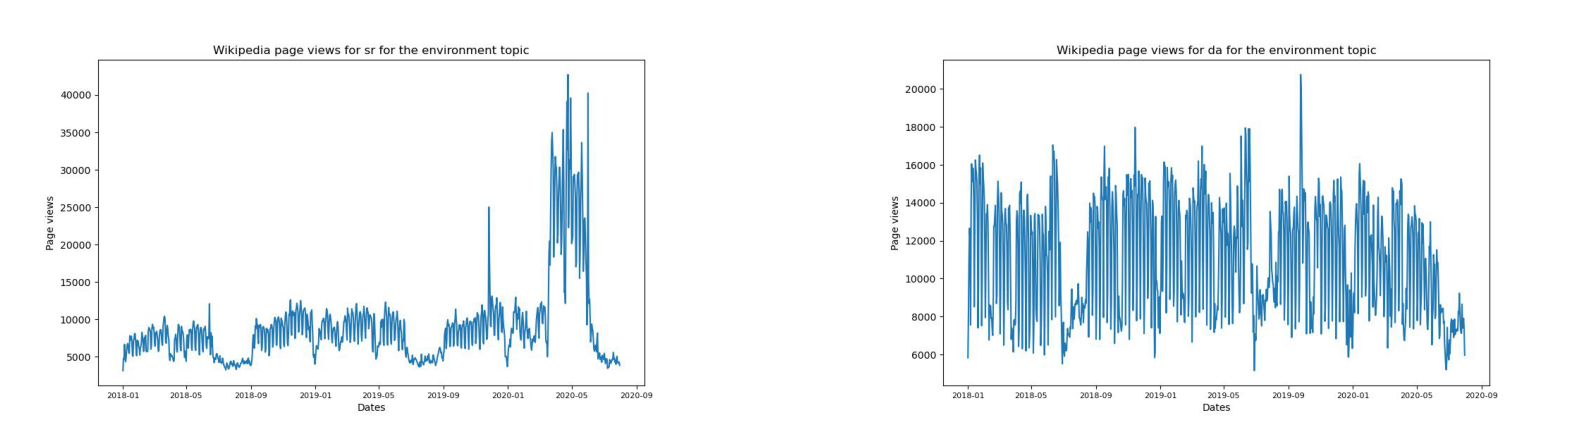

In [31]:
countries_chosen = ["sr", "da"]
fig, ax = plt.subplots(nrows=1, ncols=len(countries_chosen), figsize=(20, 10), dpi=100)
for i in range(len(countries_chosen)):
    filename = "Wikipedia page views for {} for the environment topic.jpg".format(
        countries_chosen[i]
    )
    ax[i].imshow(
        plt.imread(fname="./Figures/timeseries/topic_views/all_views/" + filename)
    )
    ax[i].axis("off")
# _ = plt.axis('off')

We can see a slight difference in behavior between these languages around the beginning of 2020:
- first, we can see that while the environment views are pretty low before 2020 for the serbian wikipedia, these views go up quickly around the end of March 2020, which when looking at the intervention data seems to coincide with the first serbian lockdown. It is still a bit early however to affirm that one of these elements caused the other.
- moving to the danish wikipedia however, there doesn't seem to be a particular rise or fall in the number of environment views.

We can also see however that for both languages, there seems to be a pattern of evolution of views between the years: for serbian, there is clear decrease between June and Septembre of both 2018 and 2019, which seems to have happened in 2020 as well if we look at the left plot. For danish the same phenomena can be observed as well, this time between July and August of both 2018 and 2019; again, this seems to have happened in 2020 as well if we were to look at the right plot. Looking at the other languages, patterns can also be found accross years.

It appears that indeed, the number of views for environmental articles did change in the same timeframe as when Covid-19 first arrived in some of the countries. It's equally important, however, to state that some don't display a change in pattern, and that at this point in the analysis we can't say that Covid-19 indeed caused more or less environment awareness on Wikipedia.

Let us now do another, more statistical analysis; we will test the hypothesis that, in average, and for every language, the average number of environmental views is the same between 2019 (pre-Covid) and 2020 (during the first, biggest wave of Covid). We will test these hypotheses using the $\alpha = 0.05 $ significance level, as well as using the Bonferonni correction $\alpha_{c} = \frac{\alpha}{n}$, with n = 14 .

We match the same date between 2019 and 2020 (up to the 31st of July, as that's when the Coronawiki data ends) for every language, and conduct a t-test for the null hypothesis described above. Note that we consider the samples to be related, as they come from the same language and for the same range of dates. In this setup, a negative t-statistic means that for that language, there are more environment views on average in 2020, and vice-versa.

In [32]:
before_covid_env_topic_views = sum_environment_df[
    (sum_environment_df.date < "2020-01-01") & (sum_environment_df.date >= "2019-01-01")
]
during_covid_env_topic_views = sum_environment_df[
    sum_environment_df.date >= "2020-01-01"
]
for language in sum_environment_df.language.unique():
    language_before = before_covid_env_topic_views[
        before_covid_env_topic_views.language == language
    ].copy()
    language_during = during_covid_env_topic_views[
        during_covid_env_topic_views.language == language
    ].copy()

    language_before.date = language_before.date.apply(
        lambda date: str(date.month) + "-" + str(date.day)
    )
    language_during.date = language_during.date.apply(
        lambda date: str(date.month) + "-" + str(date.day)
    )
    matching = pd.merge(
        language_before,
        language_during,
        on=["date", "language"],
        suffixes=["_before", "_during"],
    )
    stat, pvalue = stats.ttest_rel(
        matching["environment_views_before"], matching["environment_views_during"]
    )
    print("p-value for {0}: {1}".format(language, pvalue))
    if pvalue >= 0.05:
        print("Don't reject null when alpha = 0.05")
    if pvalue >= (0.05 / 14):
        print("Don't reject null when using the banferoni correction")
    print("Ttest statistic value for {0}: {1}".format(language, stat))
    print("------------------")

p-value for ja: 8.674434578237553e-12
Ttest statistic value for ja: -7.231241414327633
------------------
p-value for it: 0.002239652239545297
Ttest statistic value for it: -3.094339981709228
------------------
p-value for da: 8.548804022807578e-09
Ttest statistic value for da: 5.998519188316964
------------------
p-value for tr: 1.3143938876254454e-36
Ttest statistic value for tr: -15.476728178676696
------------------
p-value for no: 0.0003371702009370403
Ttest statistic value for no: 3.644641980122951
------------------
p-value for en: 5.111120077771197e-05
Ttest statistic value for en: 4.135571195327151
------------------
p-value for sr: 2.5049354455646286e-18
Ttest statistic value for sr: -9.596560924740073
------------------
p-value for sv: 3.0797434434976986e-10
Ttest statistic value for sv: 6.610574204066698
------------------
p-value for nl: 0.4461336381813529
Don't reject null when alpha = 0.05
Don't reject null when using the banferoni correction
Ttest statistic value for nl

It appears that for 11 out of 14 languages, there is indeed a change in how people visit these pages; the null hypothesis is rejected even after applying the Bonferonni correction, seeing how small their p-values are.. Out of these 11 languages, 6 observe a negative t-statistic, i.e. an average increase in 2020, while the other 5 observe a positive t-statistic, i.e an average decrease in 2020.

## Mobility data

The second type of data we have are mobility data that come from two different sources. The first one is from Apple, who stopped giving out the data in April 2022, and the second one is from Google, which is still available, and more up-to-date (17th of October).

### Apple mobility

In [33]:
apple_mobility = pd.read_csv("Data/applemobilitytrends-2020-04-20.csv.gz")
apple_mobility.head()

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,country/region,Albania,driving,100,95.30,101.43,97.20,103.55,112.67,104.83,...,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51
1,country/region,Albania,walking,100,100.68,98.93,98.46,100.85,100.13,82.13,...,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,...,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,...,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44
4,country/region,Australia,driving,100,102.98,104.21,108.63,109.08,89.00,99.35,...,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93


In [34]:
print(apple_mobility.transportation_type.unique())  # Three types of transportation
print(apple_mobility.geo_type.unique())  # Granularity

['driving' 'walking' 'transit']
['country/region' 'city']


The mobility data from Apple we have begins in mid-January 2020, and ends that same year in April. This isn't a big time window, and it doesn't appear that there is earlier data as it has been collected specifically for Covid-19 mobility tracking. We could however try to look for newer information (post-April 2020) on the web.

Three types of transportation have been tracked here: driving, walking, and transit. We also have two different granularities about the collected data: either country/world region level, or city level, which are often country capitals.

Per day and region, we have the pourcentage of the usage of every transportation mode according to some pre-pandemic baseline computed in early 2020.

In [35]:
apple_mobility[apple_mobility["region"] == "Turkey"]

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
137,country/region,Turkey,driving,100,103.22,106.28,109.51,139.77,144.21,126.23,...,15.04,19.54,43.99,41.94,40.95,45.06,44.15,15.68,22.23,50.03
138,country/region,Turkey,walking,100,100.97,104.45,105.61,133.40,141.40,100.15,...,14.58,15.69,36.97,34.10,32.68,36.88,35.99,14.23,17.34,40.61


In [36]:
apple_mobility.isnull().any().any()  # There doesn't appear to be null data, but some countries don't have all the transportation types (transit, mostly)

False

In [37]:
# Convert dates strings to date times
time_columns = pd.to_datetime(apple_mobility.columns[3:])
apple_mobility.columns = apple_mobility.columns[:3].append(time_columns)

### Global mobility from Google

In [38]:
global_mobility_report = pd.read_csv("Data/Global_Mobility_Report.csv.gz")

/var/folders/72/8yk_14s91dv0wg68db_656yr0000gn/T/ipykernel_8649/740004101.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  global_mobility_report = pd.read_csv("Data/Global_Mobility_Report.csv.gz")


In [39]:
print(
    min(global_mobility_report.date.unique()), max(global_mobility_report.date.unique())
)
global_mobility_report.date = pd.to_datetime(global_mobility_report.date)

2020-02-15 2020-08-25


The mobility data from Google we have begins in mid-February 2020, and ends that same year in August. This is more than the given Apple data, despite the fact that both collections happened in the context of Covid-19. The full data can be found in the *Outside data* folder.

There are more levels of granularity with this data: for example, for the United Arab Emirates, we might simply talk about the whole country, or it could be specified in the column *sub_region_1* that the row is actually focused on the city of Abu Dhabi. This granularity can be made finer with *sub_region_2*.

Per day and region, we have the **difference** in pourcentage usage of various location types (workplaces, etc) according to some pre-pandemic baseline computed in the early weeks of 2020. The baseline was computed *per day* , as people can have different behaviors depending on whether it's the weekend or not.

In [40]:
global_mobility_report.isnull().sum() / global_mobility_report.shape[0]

country_region_code                                   0.000709
country_region                                        0.000000
sub_region_1                                          0.018154
sub_region_2                                          0.180897
metro_area                                            0.994122
iso_3166_2_code                                       0.813653
census_fips_code                                      0.762436
date                                                  0.000000
retail_and_recreation_percent_change_from_baseline    0.363799
grocery_and_pharmacy_percent_change_from_baseline     0.373900
parks_percent_change_from_baseline                    0.536971
transit_stations_percent_change_from_baseline         0.502960
workplaces_percent_change_from_baseline               0.050385
residential_percent_change_from_baseline              0.499080
dtype: float64

As expected, we have more coarse grained data (no missing data) than finer grained (many sub_region_1 fields are null, and even more sub_region_2 as well). The metropolitan area is very rarely defined, as almost 99.4% of the field is empty values.

Looking at the differences from baseline, we remark scarcity as well; apart from workplace locations which has a missing rate of only around 5.04%, others go from 36.4% (for retail) to 53.7% (for parks).

We can look in more details at the entries which have the missing values for the differences from baseline; let's check the intersection of these missing values, to see for example if the absence of one field implies the absence of the others.

In [41]:
retail_missing = (
    global_mobility_report.retail_and_recreation_percent_change_from_baseline.isnull()
)
grocery_pharmecy_missing = (
    global_mobility_report.grocery_and_pharmacy_percent_change_from_baseline.isnull()
)
park_missing = global_mobility_report.parks_percent_change_from_baseline.isnull()
transit_stations_missing = (
    global_mobility_report.transit_stations_percent_change_from_baseline.isnull()
)
workplace_missing = (
    global_mobility_report.workplaces_percent_change_from_baseline.isnull()
)
residential_missing = (
    global_mobility_report.residential_percent_change_from_baseline.isnull()
)

In [42]:
all_missing = (
    retail_missing
    & grocery_pharmecy_missing
    & park_missing
    & transit_stations_missing
    & workplace_missing
    & residential_missing
)

In [43]:
all_missing.any()

False

From the above result, we can conclude that there doesn't appear to be a feature such that if that one is missing, then all the others are missing; this also means that for each entry, there's always at least one feature available.

## Interventions

In this data, each language is mapped to the main country of usage except for English, where the language's usage is very high in multiple countries such that it couldn't be mapped to a single country. As such, for that language, we have most of the data missing.

Per country, the pandemic timeline is represented, such as the first registered case, the first death, etc.

Note that the paper says that nine languages are spoken in a single language, but we have more than that here (reason for that unknown).

In [44]:
interventions = pd.read_csv("Data/interventions.csv")


def transform_column(column_name):
    interventions[column_name] = pd.to_datetime(interventions[column_name])


for intervention in interventions.columns[1:]:
    transform_column(intervention)
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaT,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaT,NaT,2020-02-25,2020-04-15
9,ca,2020-01-31,2020-02-13,2020-03-12,2020-03-08,2020-03-14,2020-03-16,NaT


## Topics

Simply maps each considered article to the topics it is related to. A single article can be mapped to multiple topics. The number of articles per topic can be found in the [timeseries](#timeseries) data.

In [45]:
# loading the data takes a lot of time, and it's not really used right now, so there is no real point to load it for now
# topics_linked = pd.read_csv("topics_linked.csv.xz")
# topics_linked

## Data merging

First of all, let us keep from both mobility datasets only the countries that were considered in the original timeseries. We mapped the english language to Washington DC, the catalan language to Barcelona, and the Korean language both to Seoul and South Korea.

In [46]:
country_to_wiki_code = {
    "Japan": "ja",
    "Italy": "it",
    "Denmark": "da",
    "Turkey": "tr",
    "Norway": "no",
    "Serbia": "sr",
    "Sweden": "sv",
    "Netherlands": "nl",
    "Germany": "de",
    "France": "fr",
    "Barcelona": "ca",
    "South Korea": "ko",
    "Finland": "fi",
    "District of Columbia": "en",
    "Washington DC": "en",
    "Seoul": "ko",
}

In [47]:
def map_countries_to_fine_grained(x):
    if x == "Spain":
        return "ca"
    if x == "United States":
        return "en"
    if x == "Seoul":
        return "ko"
    return country_to_wiki_code[x]


filtered_global_mobility_report = global_mobility_report[
    global_mobility_report["country_region"].isin(country_to_wiki_code)
    | global_mobility_report["sub_region_1"].isin(country_to_wiki_code)
    | global_mobility_report["sub_region_2"].isin(country_to_wiki_code)
].copy()
filtered_global_mobility_report.loc[
    :, "country_region_code"
] = filtered_global_mobility_report.country_region.apply(
    lambda x: map_countries_to_fine_grained(x)
)
filtered_global_mobility_report.index = range(len(filtered_global_mobility_report))
filtered_global_mobility_report.country_region.unique()  # There is data about all countries

array(['Germany', 'Denmark', 'Spain', 'Finland', 'France', 'Italy',
       'Japan', 'South Korea', 'Netherlands', 'Norway', 'Serbia',
       'Sweden', 'Turkey', 'United States'], dtype=object)

In [48]:
# Have to keep for each country only the capital/concerned city data from the
cities_global_mobility_report = pd.DataFrame()
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_1"] == "Tokyo"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_2"] == "Copenhagen Municipality"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_1"] == "Berlin"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_1"] == "Oslo"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_2"] == "Barcelona"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_2"] == "Helsinki"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_2"] == "Paris"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_2"]
            == "Metropolitan City of Rome"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["metro_area"] == "Seoul Metropolitan Area"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_2"] == "Government of Amsterdam"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["metro_area"]
            == "Belgrade Metropolitan Area"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_2"] == "Stockholm Municipality"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            (filtered_global_mobility_report["sub_region_1"] == "Ankara")
            & (filtered_global_mobility_report["sub_region_2"].isnull())
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_2"] == "Barcelona"
        ],
    ]
)
cities_global_mobility_report = pd.concat(
    [
        cities_global_mobility_report,
        filtered_global_mobility_report[
            filtered_global_mobility_report["sub_region_1"] == "District of Columbia"
        ],
    ]
)
cities_global_mobility_report = cities_global_mobility_report[
    [
        "country_region_code",
        "date",
        "retail_and_recreation_percent_change_from_baseline",
        "grocery_and_pharmacy_percent_change_from_baseline",
        "parks_percent_change_from_baseline",
        "transit_stations_percent_change_from_baseline",
        "workplaces_percent_change_from_baseline",
        "residential_percent_change_from_baseline",
    ]
]
cities_global_mobility_report = cities_global_mobility_report.rename(
    columns={"country_region_code": "language"}
)

In [49]:
filtered_apple_mobility = apple_mobility[
    apple_mobility["region"].isin(country_to_wiki_code)
].copy()
print(filtered_apple_mobility.region.unique())
print("-----")
filtered_apple_mobility.region = filtered_apple_mobility.region.apply(
    lambda x: country_to_wiki_code[x]
)
filtered_apple_mobility.head()

['Denmark' 'Finland' 'France' 'Germany' 'Italy' 'Japan' 'Netherlands'
 'Norway' 'Serbia' 'Sweden' 'Turkey' 'Barcelona' 'Seoul' 'Washington DC']
-----


,geo_type,region,transportation_type,2020-01-13 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00,2020-01-17 00:00:00,2020-01-18 00:00:00,2020-01-19 00:00:00,...,2020-04-11 00:00:00,2020-04-12 00:00:00,2020-04-13 00:00:00,2020-04-14 00:00:00,2020-04-15 00:00:00,2020-04-16 00:00:00,2020-04-17 00:00:00,2020-04-18 00:00:00,2020-04-19 00:00:00,2020-04-20 00:00:00
31,country/region,da,driving,100,103.67,105.55,104.16,110.40,105.47,103.52,...,71.32,71.54,73.58,77.88,80.32,82.37,85.22,80.85,84.05,85.69
32,country/region,da,transit,100,98.09,98.22,99.55,111.53,108.82,102.06,...,32.59,34.40,35.26,34.36,37.09,37.28,40.06,38.39,42.40,41.87
33,country/region,da,walking,100,99.31,104.04,107.99,131.40,126.32,96.40,...,65.98,69.45,60.65,66.49,70.92,74.24,81.08,82.95,79.49,83.64
39,country/region,fi,driving,100,102.42,105.41,104.46,117.78,120.16,112.58,...,76.06,54.91,74.72,72.53,75.78,76.80,88.83,87.21,86.59,84.52
40,country/region,fi,transit,100,98.58,99.52,101.67,104.50,101.66,98.45,...,34.02,32.26,41.28,39.78,39.22,36.50,40.39,37.89,42.44,46.86


In [50]:
new_apple_mobility = pd.DataFrame()
for language in sum_data_df.language.unique():
    tmp = (
        filtered_apple_mobility[filtered_apple_mobility["region"] == language]
        .T.iloc[2:]
        .copy()
    )
    tmp.columns = tmp.iloc[0]
    tmp = tmp.iloc[1:]
    tmp["language"] = language
    tmp["date"] = tmp.index
    new_apple_mobility = pd.concat([new_apple_mobility, tmp], axis=0)

tmp_merge1 = sum_data_df.merge(new_apple_mobility, on=["language", "date"])
tmp_merge2 = tmp_merge1.merge(sum_environment_df, on=["language", "date"])
final_merge = tmp_merge2.merge(cities_global_mobility_report, on=["date", "language"])
final_merge[["driving", "transit", "walking"]] = final_merge[
    ["driving", "transit", "walking"]
].astype(np.float64)

In [51]:
final_merge.head()

,views,language,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,32829116,ja,2020-02-15,131.54,128.41,138.76,152200,-2.0,5.0,9.0,1.0,4.0,1.0
1,37797411,ja,2020-02-16,114.42,114.64,119.97,174462,-13.0,-9.0,-37.0,-9.0,-1.0,3.0
2,34293756,ja,2020-02-17,111.43,112.88,122.20,203263,-4.0,3.0,-2.0,-1.0,1.0,0.0
3,32288981,ja,2020-02-18,111.19,112.02,122.62,190820,-2.0,3.0,3.0,-3.0,0.0,1.0
4,31509643,ja,2020-02-19,112.58,112.54,124.25,192859,-4.0,2.0,8.0,-5.0,-1.0,1.0


There is still some null data however, so we have to manage these features, either with interpolation or filling these values with the mean of the corresponding countries.

In [52]:
final_merge.isnull().any()

views                                                 False
language                                              False
date                                                  False
driving                                               False
transit                                                True
walking                                               False
environment_views                                     False
retail_and_recreation_percent_change_from_baseline    False
grocery_and_pharmacy_percent_change_from_baseline      True
parks_percent_change_from_baseline                    False
transit_stations_percent_change_from_baseline         False
workplaces_percent_change_from_baseline               False
residential_percent_change_from_baseline              False
dtype: bool

In [53]:
final_merge[final_merge.transit.isnull()].groupby("language").count()

,views,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
language,,,,,,,,,,,,
ko,66,66,66,0,66,66,66,66,66,66,66,66
sr,66,66,66,0,66,66,66,66,66,66,66,66
tr,66,66,66,0,66,66,66,66,66,66,66,66


It appears that transit data from Apple is totally missing for the Korean, Serbian and Turkish parts; as such there is no way to replace them. Let us check for the other feature

In [54]:
final_merge[
    final_merge.grocery_and_pharmacy_percent_change_from_baseline.isnull()
].groupby("language").count()

,views,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
language,,,,,,,,,,,,
de,1,1,1,1,1,1,1,0,1,1,1,1
no,1,1,1,1,1,1,1,0,1,1,1,1


In [55]:
final_merge[final_merge.grocery_and_pharmacy_percent_change_from_baseline.isnull()]

,views,language,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
328,988309,no,2020-04-19,86.32,46.41,80.64,11680,-55.0,NaN,72.0,-47.0,-34.0,8.0
658,35759887,de,2020-04-19,63.82,46.65,75.93,301591,-68.0,NaN,38.0,-50.0,-23.0,7.0


We will simply interpolate these 2 missing values with the nearest value; because it's both on the same day, and that day isn't the last one per language, the nearest value will be one for the same language.

In [56]:
final_merge[["grocery_and_pharmacy_percent_change_from_baseline"]] = final_merge[
    ["grocery_and_pharmacy_percent_change_from_baseline"]
].interpolate(method="nearest")

## Regression analysis

We can now try to do some regression analysis, with the number of environment views as output, and using the columns of *final_merge* as covariates, to see if we can fit some hyperplane to this data. First, let us transform the categorical language data using dummy variable encoding

In [57]:
final_merge = pd.get_dummies(final_merge, drop_first=True)
final_merge.head()

,views,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,...,language_fi,language_fr,language_it,language_ja,language_ko,language_nl,language_no,language_sr,language_sv,language_tr
0,32829116,2020-02-15,131.54,128.41,138.76,152200,-2.0,5.0,9.0,1.0,...,0,0,0,1,0,0,0,0,0,0
1,37797411,2020-02-16,114.42,114.64,119.97,174462,-13.0,-9.0,-37.0,-9.0,...,0,0,0,1,0,0,0,0,0,0
2,34293756,2020-02-17,111.43,112.88,122.20,203263,-4.0,3.0,-2.0,-1.0,...,0,0,0,1,0,0,0,0,0,0
3,32288981,2020-02-18,111.19,112.02,122.62,190820,-2.0,3.0,3.0,-3.0,...,0,0,0,1,0,0,0,0,0,0
4,31509643,2020-02-19,112.58,112.54,124.25,192859,-4.0,2.0,8.0,-5.0,...,0,0,0,1,0,0,0,0,0,0


Then, we will normalize the input variables, so that each column has mean 0 and standard deviation 1 (note: maybe don't do this, use a different scaling, as the data isn't necessarily gaussian, but hey we'll see)

In [58]:
all_data_columns = list(final_merge.columns[2:])
all_data_columns.remove("environment_views")
for column in all_data_columns:
    final_merge[column] = (
        final_merge[column] - final_merge[column].mean()
    ) / final_merge[column].std()

#final_merge["environment_views"] = (
#    final_merge["environment_views"] - final_merge["environment_views"].mean()
#) / final_merge["environment_views"].std()

In [59]:
formula = ""
for covariate in all_data_columns:
    formula = covariate + "+" + formula


formula = formula[: len(formula) - 1]
# formula = formula[120:]
# formula = formula[72:]

First we will use all covariates as predictors, with no interactions between them.

In [60]:
mod = smf.ols(formula="""environment_views ~ """ + formula, data=final_merge)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      environment_views   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3007.
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:25:41   Log-Likelihood:                -9832.0
No. Observations:                 792   AIC:                         1.970e+04
Df Residuals:                     772   BIC:                         1.980e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

We're being told in the warnings that there either, there are strong multicollinearity problems, or the design matrix isn't invertible. This might be because of the "dummy variable trap" where, after using dummy encoding, many of the created features can be explained by the others. The condition number is also pretty high, which means that the matrix is easily perturbed by variation in the input data. We will try to fit a different model with less of the dummy variables to see if we can get rid of this issue.

We also use less data points than we have; these correspond to the three languages that don't have the Apple transit data, i.e Turkish, Serbian and Korean. We will first try to get rid of that feature for the next regression analysis

In [61]:
features_to_exclude_all = [
    "language_da",
    "language_de",
    "language_en",
    "language_fi",
    "language_fr",
    "language_it",
    "language_ja",
    "language_ko",
    "language_nl",
    "language_no",
    "language_sr",
    "language_sv",
    "language_tr",
]
features_to_exclude = [
    "transit",
]
data_columns = list(set(all_data_columns) - set(features_to_exclude))
formula = ""
for covariate in data_columns:
    formula = covariate + "+" + formula


formula = formula[: len(formula) - 1]
# formula = formula[120:]
# formula = formula[72:]

In [62]:
mod = smf.ols(formula="""environment_views ~ """ + formula, data=final_merge)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      environment_views   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3407.
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:25:41   Log-Likelihood:                -12198.
No. Observations:                 990   AIC:                         2.444e+04
Df Residuals:                     968   BIC:                         2.455e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Here, we got rid of the Apple transit feature, which makes us able to use all the data points we have. This gets rid of the warning that we used to have, meaning that we don't have multicollinearity problems anymore, and the data matrix is invertible. We can then now try to interpret the model.

The R-squared is the same as before, i.e the part of explained variance is equal to 98.7%. Some of the features are not singificant, as their p-value is bigger than 0.05, so one can try to fit the model without these features.

Looking at the covariates themselves, we see that it is useful to have the language data, as obviously the range of views from one country to another can change significantly as Wikipedia's importance isn't the same everywhere.

From the Apple mobility data, it appears that the driving feature isn't statistically significant (0.221), while the walking one is. Surprisingly, it appears that walking is associated in a decrease of environmental views, which can be a bit counter-intuitive.

From the statistically significant features from Global mobility data, it appears that a positive change in the residential pourcentage results in more environmental views.

**Conclusion**

With this first analysis, we can already extract some interesting insight about people's environmental (or lack thereof) awareness during the first Covid crisis: 

* we have shown that statistically speaking, there appears indeed to be a difference in how people visit these pages between 2019 and 2020, from January to July. 
* plotting these views as timeseries, we can sometimes see this change of pattern clearly, with an increase generally around March/April 2020
* performing a regression analysis explains the data quiet well, and we can try different interactions between features to see if we can gain more insight that way

# Precise Wikipedia Views Analysis

The goal of this section is to precisely analyse the views of different wikipedia pages (Air pollution, Plastic pollution, and plastic production) from 01/01/2019 to 01/09/2022.

## Data import

In [63]:
# We restrict the page to the language studied in coronawiki
languages = [
    "ja",
    "it",
    "da",
    "tr",
    "no",
    "en",
    "sr",
    "sv",
    "nl",
    "de",
    "fr",
    "ca",
    "ko",
    "fi",
]

In [64]:
def process_langviews_data(path, columns_to_keep=None):
    """
    Convert the csv generated by langviews for a particular wikipedia page into a usable dataframe keeping only the pages in the specified languages.
    The resulting dataframe has a column per language and a new total column giving the total number of views across all the studied languages.
    """

    data = pd.read_csv(path).transpose()
    data.columns = data.iloc[0]
    titles = data.iloc[1]
    data.drop(["Language", "Title", "Badges"], inplace=True)

    if columns_to_keep is None:
        columns_to_keep = data.columns

    columns = data.columns.intersection(columns_to_keep)
    data = data[columns]

    data["total"] = data.sum(axis=1)
    data["date"] = data.index
    data["date"] = pd.to_datetime(data["date"])
    data["year"] = data.apply(lambda x: x.date.year, axis=1)

    return titles, data

#### Air Pollution

In [65]:
airpol_titles, airpol_data = process_langviews_data(
    "Data/Additional/wikiviews/page-views-airpol.csv", languages
)
airpol_data

Language,en,fr,it,ja,de,tr,sr,nl,ko,ca,fi,sv,no,da,total,date,year
2015-07-01,4647,150,86,316,235,17,10,26,24,9,4,2,4,2,5532.0,2015-07-01,2015
2015-07-02,4373,152,94,301,187,9,1,21,10,7,6,6,5,3,5175.0,2015-07-02,2015
2015-07-03,3429,155,88,240,96,6,5,17,3,11,3,2,5,1,4061.0,2015-07-03,2015
2015-07-04,3328,97,44,145,66,14,3,32,4,1,0,2,2,0,3738.0,2015-07-04,2015
2015-07-05,4541,73,56,243,129,10,7,34,11,3,3,8,3,2,5123.0,2015-07-05,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,3286,205,73,159,44,50,54,30,51,23,2,15,1,1,3994.0,2022-10-28,2022
2022-10-29,2818,236,40,54,26,59,37,11,20,17,7,3,1,2,3331.0,2022-10-29,2022
2022-10-30,3712,273,57,56,55,56,64,14,52,10,7,5,0,4,4365.0,2022-10-30,2022
2022-10-31,4158,268,52,181,51,107,161,22,77,12,14,7,1,0,5111.0,2022-10-31,2022


#### Plastic Industry

In [66]:
plastin_titles, plastin_data = process_langviews_data(
    "Data/Additional/wikiviews/page-views-plastin.csv", languages
)
plastin_data

Language,en,fr,fi,de,total,date,year
2019-01-01,72,1,1,0,74.0,2019-01-01,2019
2019-01-02,145,1,5,0,151.0,2019-01-02,2019
2019-01-03,129,0,4,2,135.0,2019-01-03,2019
2019-01-04,181,1,3,1,186.0,2019-01-04,2019
2019-01-05,98,1,4,0,103.0,2019-01-05,2019
...,...,...,...,...,...,...,...
2022-11-04,72,9,1,11,93.0,2022-11-04,2022
2022-11-05,59,18,1,7,85.0,2022-11-05,2022
2022-11-06,56,15,3,3,77.0,2022-11-06,2022
2022-11-07,65,10,6,7,88.0,2022-11-07,2022


#### Plastic Pollution

In [67]:
plastpol_titles, plastpol_data = process_langviews_data(
    "Data/Additional/wikiviews/page-views-plastpol.csv", languages
)
plastpol_data

Language,en,it,fr,ko,da,ca,tr,de,nl,sr,total,date,year
2015-07-01,958,6,4,0,0,0,0,0,0,0,968.0,2015-07-01,2015
2015-07-02,1123,10,7,0,0,0,0,0,0,0,1140.0,2015-07-02,2015
2015-07-03,808,3,5,0,0,0,0,0,0,0,816.0,2015-07-03,2015
2015-07-04,729,10,4,0,0,0,0,0,0,0,743.0,2015-07-04,2015
2015-07-05,1172,10,2,0,0,0,0,0,0,0,1184.0,2015-07-05,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,797,42,22,35,1,1,5,10,15,0,928.0,2022-10-28,2022
2022-10-29,600,33,22,11,0,0,6,2,3,0,677.0,2022-10-29,2022
2022-10-30,830,23,21,34,0,0,6,2,1,0,917.0,2022-10-30,2022
2022-10-31,728,44,28,74,1,0,3,4,43,0,925.0,2022-10-31,2022


### Covid-19

In [68]:
covid_titles, covid_data = process_langviews_data(
    "Data/Additional/wikiviews/page-views-covid19.csv", languages
)
covid_data

Language,en,de,it,fr,nl,ja,tr,fi,ko,sv,da,ca,no,sr,total,date,year
2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2018-01-01,2018
2018-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2018-01-02,2018
2018-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2018-01-03,2018
2018-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2018-01-04,2018
2018-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2018-01-05,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,20411,1870,2709,1254,461,1149,415,298,227,155,64,77,85,22,29197.0,2021-12-27,2021
2021-12-28,21443,2070,2983,1363,512,1059,428,383,261,163,94,80,65,31,30935.0,2021-12-28,2021
2021-12-29,23268,2250,3105,1468,672,1094,452,432,228,178,103,63,79,43,33435.0,2021-12-29,2021
2021-12-30,23472,1872,3173,1370,601,1016,459,392,410,224,84,65,110,23,33271.0,2021-12-30,2021


## Visualization

### Air Pollution

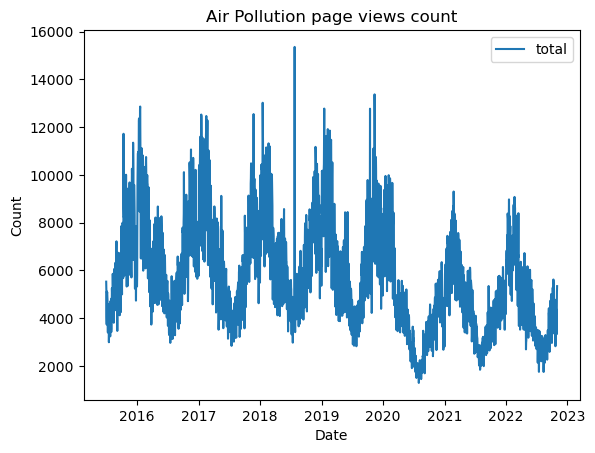

In [69]:
# sns.lineplot(y=airpol_views.en, x=airpol_views.date)
# sns.lineplot(y=airpol_views.da, x=airpol_views.date)
sns.lineplot(y=airpol_data.total, x=airpol_data.date)
plt.title("Air Pollution page views count")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["total"])
plt.show()

<AxesSubplot: xlabel='year', ylabel='total'>

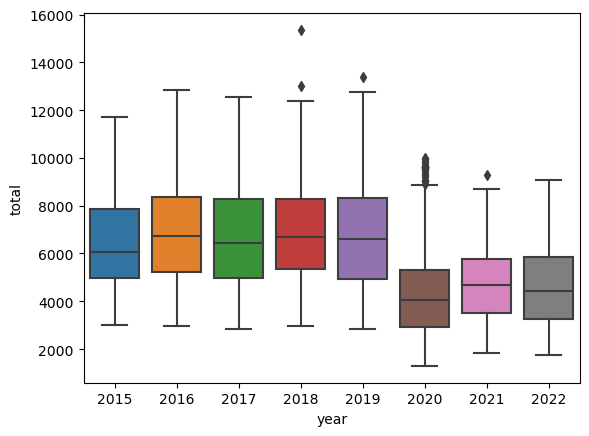

In [70]:
sns.boxplot(y=airpol_data.total, x=airpol_data.year)

It seems that during and after COVID, interest in air pollution decreases significantly

### Plastic Industry

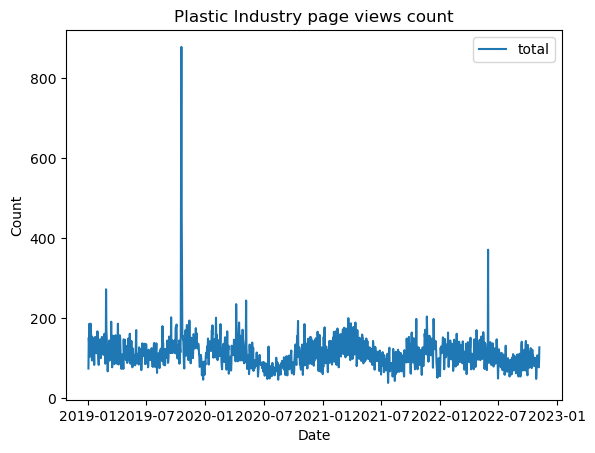

In [71]:
sns.lineplot(y=plastin_data.total, x=plastin_data.date)
plt.title("Plastic Industry page views count")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["total"])
plt.show()

There are not enough views to conclude anything about awareness on this topic.

### Plastic Pollution

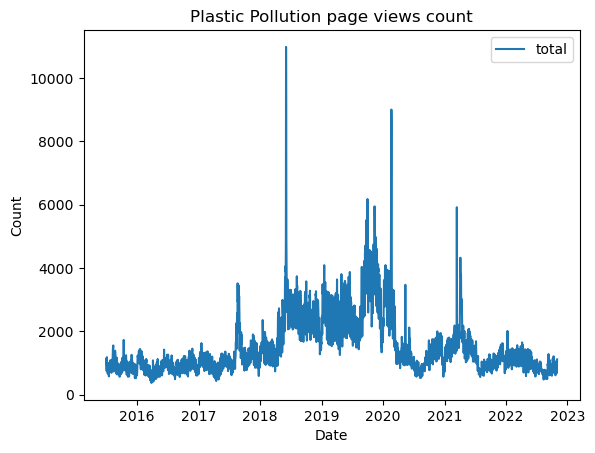

In [72]:
sns.lineplot(y=plastpol_data.total, x=plastpol_data.date)
plt.title("Plastic Pollution page views count")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["total"])
plt.show()

<AxesSubplot: xlabel='year', ylabel='total'>

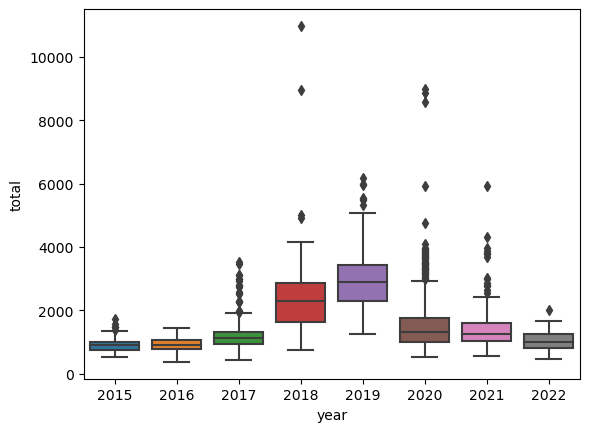

In [73]:
sns.boxplot(y=plastpol_data.total, x=plastpol_data.year)

# Analysis of nitrogen dioxide levels by capital city

Nitrogen dioxide is a toxic molecule that is typically emitted by industrial activities and car engines. It is therefore a very good indicator of human-induced air pollution.

Here, we will focus on understanding the link between Covid and NO2 air pollution, i.e. between Covid and human-induced air pollution. To do so, we will make the following assumptions :
- 2019 is the year that represents the "usual activities" before Covid.
- The year of lockdowns and restrictions is then obviously 2020. We also consider that 2021-22 are the beginning of efforts towards going back to the normal, pre-Covid life. We do not assume that 2021 and 2022 have succeeded at being "back to normal".

This might be a simplification of reality, but it has the two following advantages :
- Covid began spreading worldwide during the very beginning of 2020. We can exploit this to our advantage by splitting years at the beginning of January, which is easy and fits our assumptions well.
- It makes for very easy cross-coutries, cross-years comparisons.
- Using instead lockdown data instead of year-by-year separations would weaken the possibility of comparing pollution by country, as pollution emissions are very dependent on the period of the year.

The goal of this section is then to establish (or not) the fact that during Covid, the air got significantly cleaner, and to quantify the margin of improvement. We also consider the recovery phase after the initial Covid wave, i.e. after 2020.

## Data loading

We use air pollution data from the different capitals from the World Air Quality Index dataset for the Covid-19 period (https://aqicn.org/data-platform/covid19/). This is a reliable dataset that was used in various large-scale studies about worldwide air pollution. This dataset is fairly lage, it includes the data for the years 2018 to 2022 for many cities of the world, and for various air polluting molecules.

We reduce this to NO2 and only the fourteen capital cities in the notebook "air_quality_by_capital.ipynb", reducing the dataset to a much more manageable size, but not to the point of losing all interesting information.

Note : we don't consider country-wide pollution because the dataset does not provide us with a way to merge all cities into one large blob for the country : we don't have the city size, the geographic proportion of the city in the country, etc. We therefore study capitals only, which the dataset certainly provides.

In [74]:
path_to_datasets = "Data/Additional/waqi/no2_capital/"
capitals = [
    "tokyo",
    "rome",
    "copenhagen",
    "ankara",
    "oslo",
    "washington",
    "stockholm",
    "belgrade",
    "amsterdam",
    "berlin",
    "paris",
    "barcelona",
    "seoul",
    "helsinki",
]

In [75]:
full_datasets = []
for capital in capitals:
    full_datasets.append((capital, pd.read_csv(path_to_datasets + capital + ".csv")))

In [76]:
full_datasets[1][1]

,Date,Country,City,Specie,median
0,2018-12-31,IT,Rome,no2,17.9
1,2019-01-01,IT,Rome,no2,11.9
2,2019-01-02,IT,Rome,no2,12.8
3,2019-01-03,IT,Rome,no2,11.5
4,2019-01-04,IT,Rome,no2,13.3
...,...,...,...,...,...
1390,2022-10-27,IT,Rome,no2,19.7
1391,2022-10-28,IT,Rome,no2,18.8
1392,2022-10-29,IT,Rome,no2,16.5
1393,2022-10-30,IT,Rome,no2,13.8


In [77]:
ds_2019 = []
for (capital, dataset) in full_datasets:
    # keep year 2019
    ds = dataset[dataset.Date.str.startswith("2019")].copy()
    # remove year from date string to allow for inner merge on date with other years later on
    ds["yearlessDate"] = ds.Date.str[5:]
    # remove all other columns
    ds = ds[["yearlessDate", "median"]]
    ds_2019.append((capital, ds))

In [78]:
# same thing as above, but for 2020
ds_2020 = []
for (capital, dataset) in full_datasets:
    ds = dataset[dataset.Date.str.startswith("2020")].copy()
    ds["yearlessDate"] = ds.Date.str[5:]
    ds = ds[["yearlessDate", "median"]]
    ds_2020.append((capital, ds))

In [79]:
ds_2021 = []
for (capital, dataset) in full_datasets:
    ds = dataset[dataset.Date.str.startswith("2021")].copy()
    ds["yearlessDate"] = ds.Date.str[5:]
    ds = ds[["yearlessDate", "median"]]
    ds_2021.append((capital, ds))

In [80]:
ds_2022 = []
for (capital, dataset) in full_datasets:
    ds = dataset[dataset.Date.str.startswith("2022")].copy()
    ds["yearlessDate"] = ds.Date.str[5:]
    ds = ds[["yearlessDate", "median"]]
    ds_2022.append((capital, ds))

## Data viz

We will then plot the SO3 measurements in all 14 cities every day for the years 2019, 2020 and 2021.

We could also easily plot the current data for 2022, but we found that the resulting graph was fairly overloaded.

We use a log scale because these cities have strong differences in air quality, and we want to show the full detail.

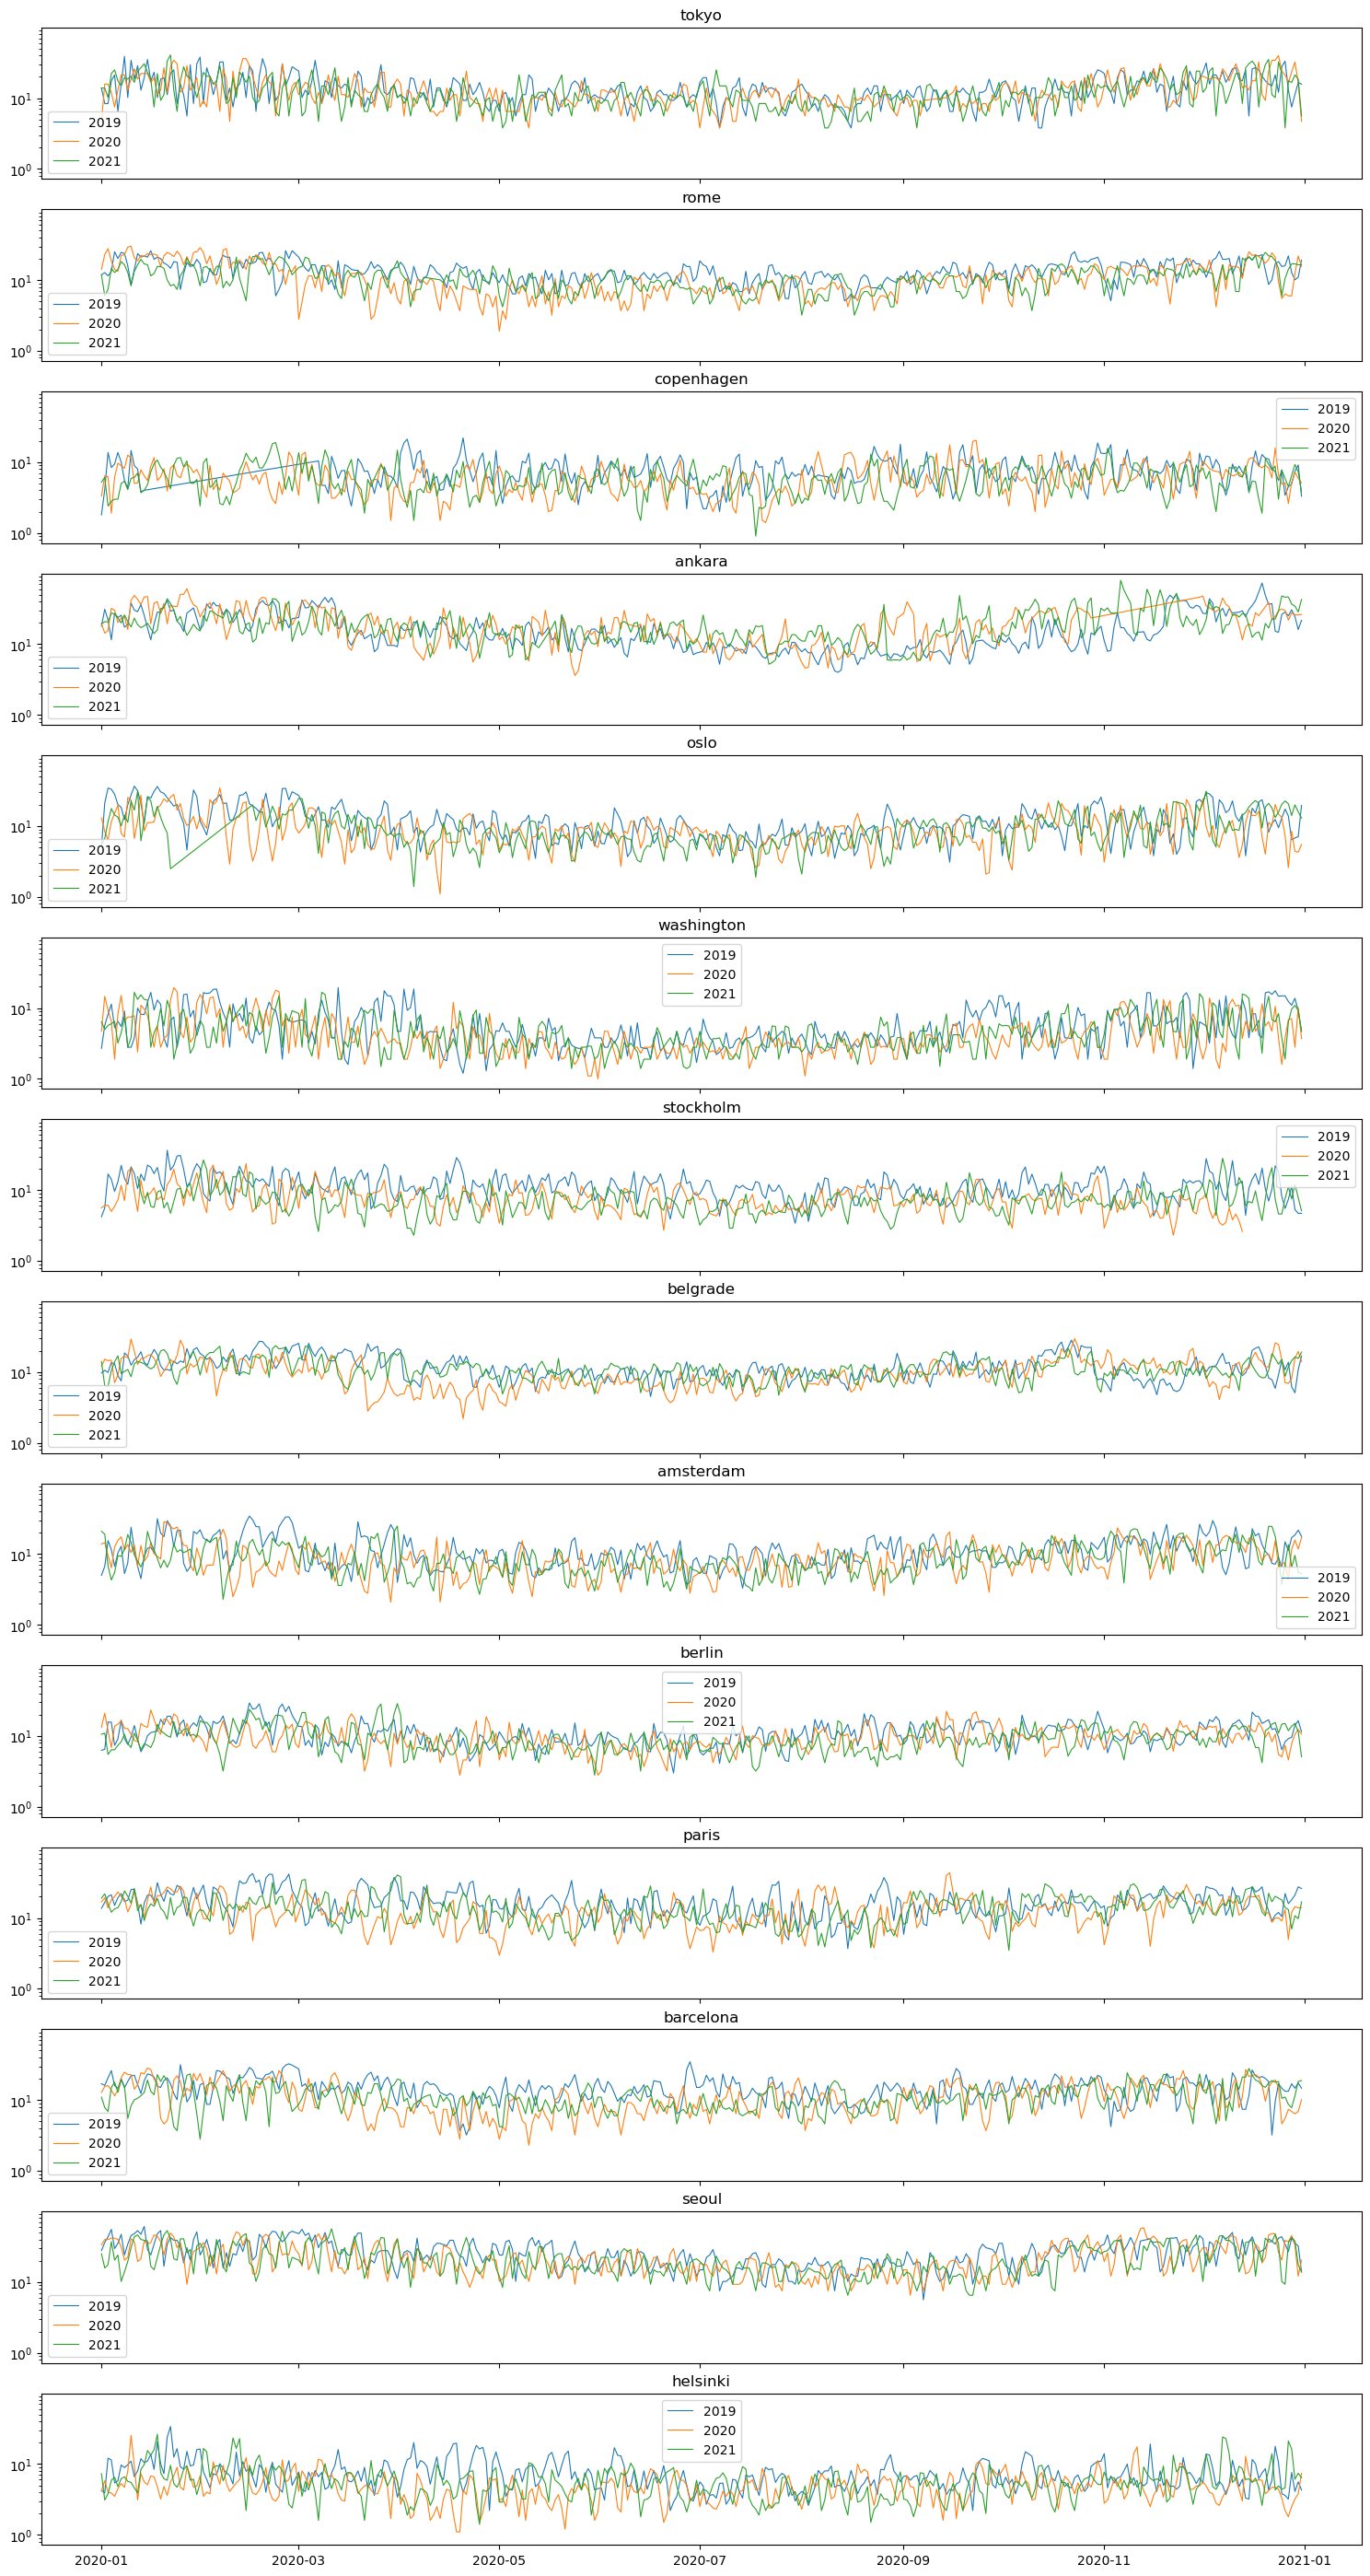

In [81]:
fig, ax = plt.subplots(14, sharex=True, sharey=True)
fig.set_size_inches(18.5, 35.5)
for i in range(14):
    ds1 = ds_2019[i][1]
    ds2 = ds_2020[i][1]
    ds3 = ds_2021[i][1]
    # not 2022, see above

    ax[i].set_yscale("log")
    ax[i].set_title(ds_2019[i][0])
    # always 2020 because we want all three graphs on one year, and 2020 is a leap year
    (p2019,) = ax[i].plot_date(
        matplotlib.dates.datestr2num("2020-" + ds1["yearlessDate"]),
        ds1["median"],
        tz="UTC+1",
        fmt="-",
        linewidth=0.8,
    )
    (p2020,) = ax[i].plot_date(
        matplotlib.dates.datestr2num("2020-" + ds2["yearlessDate"]),
        ds2["median"],
        tz="UTC+1",
        fmt="-",
        linewidth=0.8,
    )
    (p2021,) = ax[i].plot_date(
        matplotlib.dates.datestr2num("2020-" + ds3["yearlessDate"]),
        ds3["median"],
        tz="UTC+1",
        fmt="-",
        linewidth=0.8,
    )
    ax[i].legend([p2019, p2020, p2021], ["2019", "2020", "2021"])

Some trends emerge :
- 2019 (in blue) is usually a little bit above the others. When considering that this is a log scale, this is actually a fairly impressive difference.
- 2020 is typically lower. We can almost always find a drop in March 2020, where the international community initially reacted to the virus.
- 2020 and 2021 are somewhat more difficult to discern. It could be that these years are similar in terms of NO2 pollution.

We can also check the evolution of mean pollution per country per year :

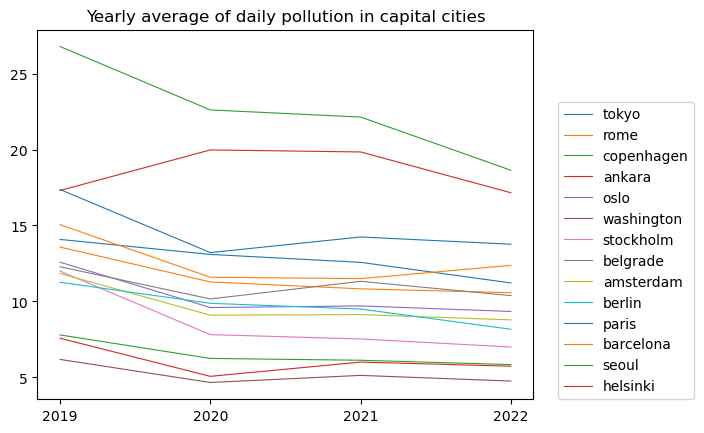

In [82]:
means2019 = [df["median"].mean() for (capital, df) in ds_2019]
means2020 = [df["median"].mean() for (capital, df) in ds_2020]
means2021 = [df["median"].mean() for (capital, df) in ds_2021]
means2022 = [df["median"].mean() for (capital, df) in ds_2022]


plt.title("Yearly average of daily pollution in capital cities")

for i in range(len(capitals)):
    plt.plot(
        ["2019", "2020", "2021", "2022"],
        [means2019[i], means2020[i], means2021[i], means2022[i]],
        linewidth=0.8,
        label=capitals[i],
    )

plt.legend(loc=(1.05, 0))
plt.show()

Perhaps surprisingly, the graph is not U-shaped at all ! This means that on average, air pollution in the capital cities goes down steadily year after year. There is a caveat : the year 2022 is not over as we write these words. This means that the end of autumn and beginning of winter 2022 are not accounted for in this graph. If winter is more polluted than summer in 2022, then the graph above underestimates the pollution average for 2022.

We can then quantify this evolution exactly, by using statistics.

## Statistical testing

The testing we will perform consists of the following :
- First, we merge the pollution data of two years
- Then, for each capital city, we do a paired test comparing pairs of (day, day) of both years
- The two days are always on the same date, except for the year. This enables us to compare pollution day by day, ignoring the effects of recurring seasonal pollution. This analysis works for 2022, as the missing data for the end of the year will be ignored in the other dataset, possibly making the compromise of increasing the variance of test statistics.

We first merge years we want to compare. We will compare the following pairs : (2019-2020) to check if covid had an impact against the 2019 baseline, (2020-2021) to see if 2021 was a rebounce/drop from Covid, and (2020, 2022) for the same reason.

In [83]:
merged19_20 = []
for index in range(len(capitals)):
    (capital1, df1) = ds_2019[index]
    (capital2, df2) = ds_2020[index]
    assert capital1 == capital2
    mergeTwoYears = pd.merge(df1, df2, on="yearlessDate", how="inner")
    merged19_20.append((capitals[index], mergeTwoYears))

merged20_21 = []
for index in range(len(capitals)):
    (capital2, df2) = ds_2020[index]
    (capital3, df3) = ds_2021[index]
    assert capital2 == capital3
    mergeTwoYears = pd.merge(df2, df3, on="yearlessDate", how="inner")
    merged20_21.append((capitals[index], mergeTwoYears))

merged20_22 = []
for index in range(len(capitals)):
    (capital2, df2) = ds_2020[index]
    (capital4, df4) = ds_2022[index]
    assert capital2 == capital4
    mergeTwoYears = pd.merge(df2, df4, on="yearlessDate", how="inner")
    merged20_22.append((capitals[index], mergeTwoYears))

We can then do the daily paired test for the year pairs :

2019 to 2020 comparison :

In [84]:
test_by_capital = []
for capital, merger in merged19_20:
    ttest = stats.ttest_rel(merger.median_x, merger.median_y, alternative="greater")
    alone_sig = ttest.pvalue < 0.05
    bonf_sig = ttest.pvalue < (0.05 / 14)
    evolution = (
        "{:+.2f}".format(
            ((np.mean(merger.median_y) / np.mean(merger.median_x)) - 1) * 100
        )
        + "%"
    )

    test_by_capital.append((capital, len(merger), evolution, alone_sig, bonf_sig))

pd.DataFrame(
    test_by_capital,
    columns=[
        "Capital",
        "numpoints",
        "pollution_evolution",
        "better_during_covid_significant",
        "bonferroni_significant",
    ],
)

,Capital,numpoints,pollution_evolution,better_during_covid_significant,bonferroni_significant
0,tokyo,358,-7.40%,True,False
1,rome,364,-16.94%,True,True
2,copenhagen,314,-20.84%,True,True
3,ankara,324,+19.52%,False,False
4,oslo,365,-23.72%,True,True
5,washington,365,-24.48%,True,True
6,stockholm,345,-35.08%,True,True
7,belgrade,364,-17.12%,True,True
8,amsterdam,365,-23.14%,True,True
9,berlin,365,-12.25%,True,True


Here, we learn that for almost every capital city, the air was significantly cleaner in during Covid times than before. There is an exception for Ankara in Turkey, which is the only capital city that polluted more during Covid than before. Tokyo is not Bonferroni-significant, but also shows a drop in average pollution during Covid.

In [85]:
test_by_capital = []
for capital, merger in merged20_21:
    # NOTE : we switch to two-sided testing because we are interested in both kinds of changes.
    # Before, we were only interested in knowing whether covid was an improvement or not
    ttest = stats.ttest_rel(merger.median_x, merger.median_y, alternative="two-sided")
    alone_sig = ttest.pvalue < 0.05
    bonf_sig = ttest.pvalue < (0.05 / 14)
    evolution = (
        "{:.2f}".format(
            ((np.mean(merger.median_y) / np.mean(merger.median_x)) - 1) * 100
        )
        + "%"
    )

    test_by_capital.append((capital, len(merger), evolution, alone_sig, bonf_sig))

pd.DataFrame(
    test_by_capital,
    columns=[
        "Capital",
        "numpoints",
        "pollution_evolution",
        "alone_significant",
        "bonferroni_significant",
    ],
)

,Capital,numpoints,pollution_evolution,alone_significant,bonferroni_significant
0,tokyo,359,-3.88%,False,False
1,rome,359,-4.30%,False,False
2,copenhagen,365,-1.96%,False,False
3,ankara,321,-6.76%,True,False
4,oslo,341,5.71%,False,False
5,washington,365,9.90%,True,False
6,stockholm,333,-2.52%,False,False
7,belgrade,365,11.41%,True,True
8,amsterdam,365,0.33%,False,False
9,berlin,365,-3.87%,False,False


Here, the results are much less significant, as the test could not manage to find a lot of cities where 2020 and 2021 were somehow different. We only have Belgrade (Serbia) and Helsinki (Finland) that showed a significant boost in pollution between 2020 and 2021. In this sense, the years 2020 and 2021 and very much alike.

In [86]:
test_by_capital = []
for capital, merger in merged20_22:
    ttest = stats.ttest_rel(merger.median_x, merger.median_y, alternative="two-sided")
    alone_sig = ttest.pvalue < 0.05
    bonf_sig = ttest.pvalue < (0.05 / 14)
    evolution = (
        "{:.2f}".format(
            ((np.mean(merger.median_y) / np.mean(merger.median_x)) - 1) * 100
        )
        + "%"
    )

    test_by_capital.append((capital, len(merger), evolution, alone_sig, bonf_sig))

pd.DataFrame(
    test_by_capital,
    columns=[
        "Capital",
        "numpoints",
        "pollution_evolution",
        "alone_significant",
        "bonferroni_significant",
    ],
)

,Capital,numpoints,pollution_evolution,alone_significant,bonferroni_significant
0,tokyo,300,-5.62%,True,False
1,rome,303,-0.59%,False,False
2,copenhagen,306,-3.12%,False,False
3,ankara,296,-10.79%,True,True
4,oslo,305,0.21%,False,False
5,washington,306,9.62%,True,False
6,stockholm,304,-13.54%,True,True
7,belgrade,306,7.23%,True,False
8,amsterdam,306,4.38%,False,False
9,berlin,306,-15.72%,True,True


This is perhaps the surprise of this study. We find that between 2020 and 2022, the only significant changes show that the cities are doing better in 2022 in terms of air pollution, the only exception being Barcelona (Spain).

## Conclusion

Let us then conclude about the NO2 air pollution. We have established the following :
- Air pollution typically goes down with time in the fourteen capital cities we studied.
- The year 2020 is special, as it shows a massive drop worldwide. We attribute this to Covid.
- The air pollution typically does not go back up after Covid. This is surprising, as one might expect air pollution to go back up after the lockdowns are finished. This is not the case.

There are a few limitations in this study :
- We do not study pollution by country, but by capital city. If we want to draw nationwide conclusions, we need to assume that the pollution of the capital city is a good proxy for the country. This may or may not be the case.
- We assumed that we could split the timeline (before, during, after) as (2019, 2020, 2021+). This is a decent compromise in order to be able to compare the evolution country-wise, but it can be a bit rough.

This concludes this study about air pollution.

# Plastic pollution

In [87]:
global_plastic = pd.read_csv("Data/Additional/plastic/global-plastics-production.csv")
# source : https://ourworldindata.org/plastic-pollution
global_plastic = global_plastic.rename(
    columns={"Global plastics production": "Global_plastics_production"}
)
global_plastic

,Entity,Code,Year,Global_plastics_production
0,World,OWID_WRL,1950,2000000
1,World,OWID_WRL,1951,2000000
2,World,OWID_WRL,1952,2000000
3,World,OWID_WRL,1953,3000000
4,World,OWID_WRL,1954,3000000
...,...,...,...,...
65,World,OWID_WRL,2015,381000000
66,World,OWID_WRL,2016,400050000
67,World,OWID_WRL,2017,420052500
68,World,OWID_WRL,2018,441055125


In [88]:
oecd = pd.read_excel("Data/Additional/plastic/oecd_source.xlsx")
# source: https://www.oecd.org/newsroom/plastic-pollution-is-growing-relentlessly-as-waste-management-and-recycling-fall-short.htm
oecd = oecd.dropna().rename(
    columns={
        "Unnamed: 0": "Region",
        "Unnamed: 1": "2020",
        "Unnamed: 2": "2019",
        "Unnamed: 3": "pre-COVID 2020 projection",
        "Unnamed: 4": "Absolute 2020 versus 2019",
    }
)
oecd = oecd.iloc[1:, :]

## Looking at the difference between the amount of plastic produced in 2020 and 2019 per region

[Text(0.5, 1.0, 'difference between the amount of plastic produced in 2020 and 2019 per region')]

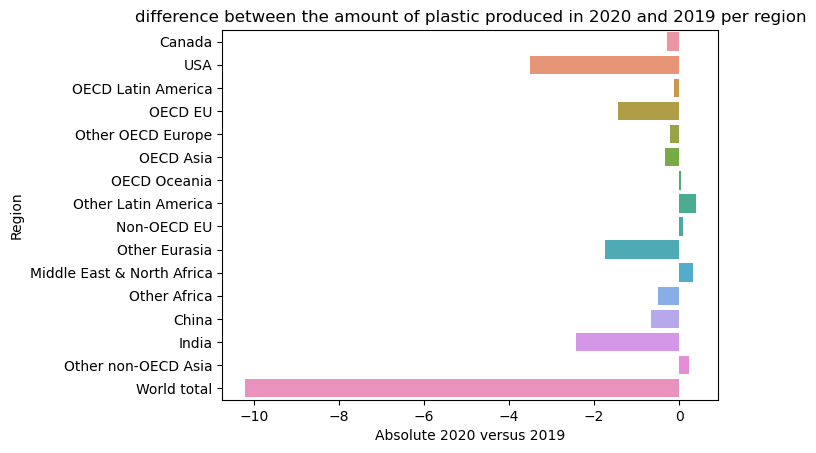

In [89]:
sns.barplot(data=oecd, x="Absolute 2020 versus 2019", y="Region").set(title="difference between the amount of plastic produced in 2020 and 2019 per region")

[Text(0.5, 1.0, 'global plastic production per year from 1950 to 2019')]

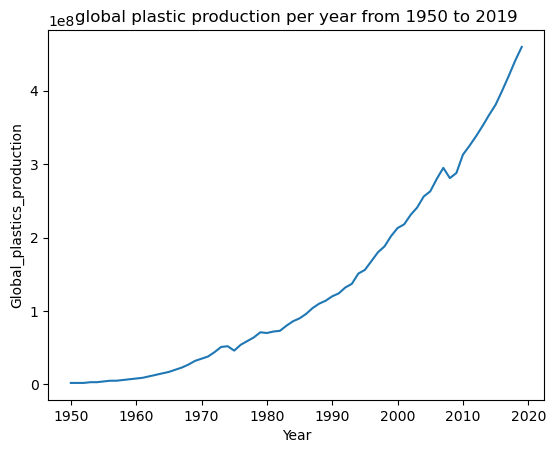

In [90]:
# we dont have 2020 data here
sns.lineplot(data=global_plastic, x="Year", y="Global_plastics_production").set(title="global plastic production per year from 1950 to 2019")

Now we want to fit a regression model in order to predict what will be the global plastic production in 2020 given the data from 1950 to 2019, the goal is to see how much higher that number would have been if covid was not there 

In [91]:
mod = smf.ols(
    formula="Global_plastics_production ~ +np.exp(Year/1950) +Year ",
    data=global_plastic,
)
model = mod.fit()
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     Global_plastics_production   R-squared:                       0.996
Model:                                    OLS   Adj. R-squared:                  0.996
Method:                         Least Squares   F-statistic:                     8739.
Date:                        Tue, 22 Nov 2022   Prob (F-statistic):           9.89e-82
Time:                                10:25:47   Log-Likelihood:                -1212.6
No. Observations:                          70   AIC:                             2431.
Df Residuals:                              67   BIC:                             2438.
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

Text(0.5, 1.0, 'The regression model')

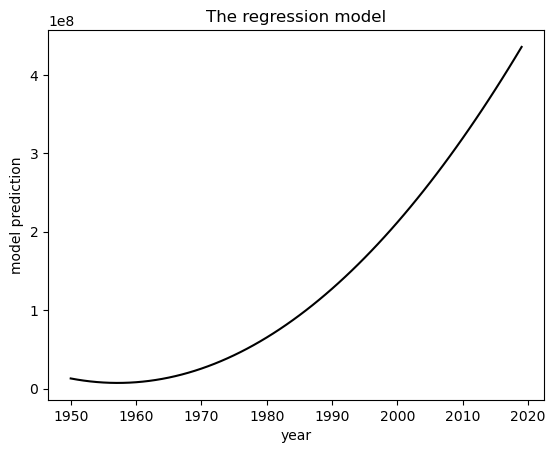

In [92]:
X = global_plastic["Year"]
plt.plot(X, model.predict(X), color="k", label="Regression model")

plt.xlabel('year') 
plt.ylabel('model prediction') 
plt.title('The regression model') 

In [93]:
data = dict(Year=2020)

d2020 = pd.DataFrame(data, index=[0])
plastic_prediction_2020_if_not_covid = model.predict(d2020)
real_plastic_prodction_2020=oecd['2020'][49]*10**6

In [94]:
poucentage_de_reduction=((real_plastic_prodction_2020 - plastic_prediction_2020_if_not_covid) / plastic_prediction_2020_if_not_covid) * 100
print(poucentage_de_reduction[0])

-0.062373006281235564


We can see that compared to our prediction the amount of plastic produced in 2020 is 0.06% smaller

## Studying the plastic production in the EU
In the first part we study the plastic produced for food packaging, Then the whole amount of plastic produced 

In [95]:
eu_plastic_packaging = pd.read_csv(
    "Data/Additional/plastic/sts_inpr_m__custom_3782744_linear.csv"
)
# source= https://ec.europa.eu/eurostat/databrowser/view/STS_INPR_M/default/table?lang=en production of plastic packages in europe

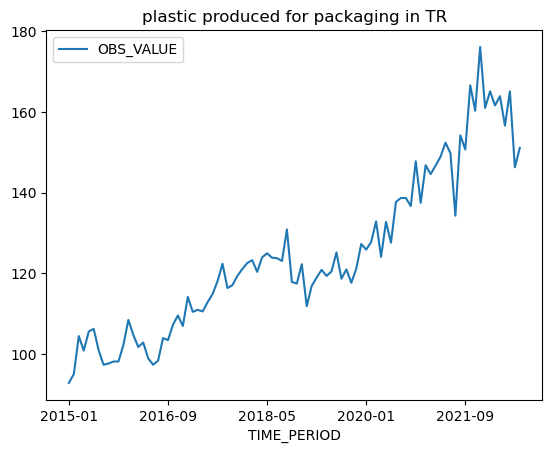

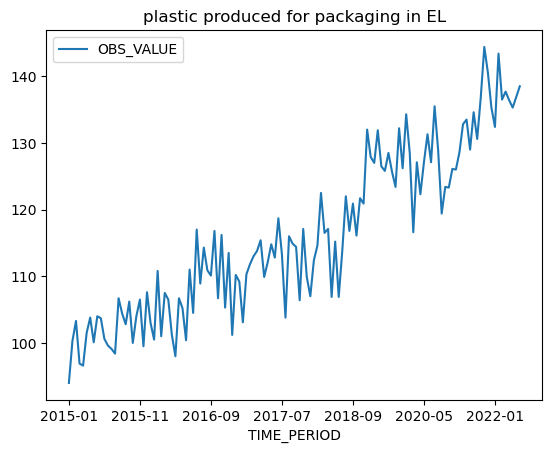

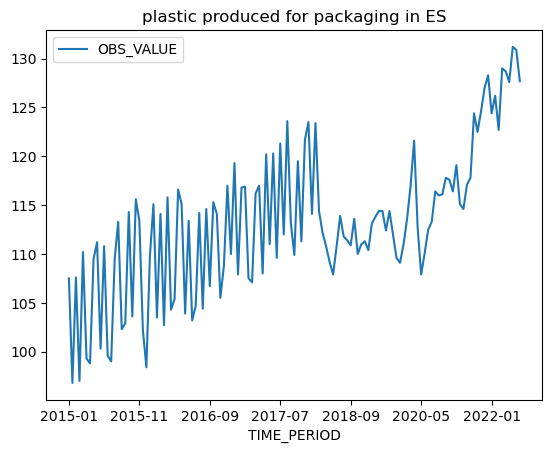

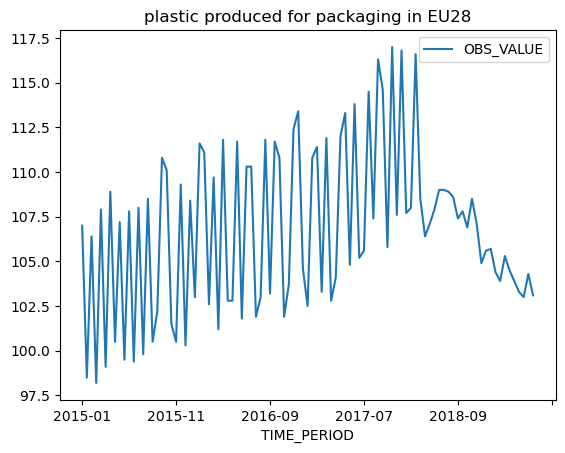

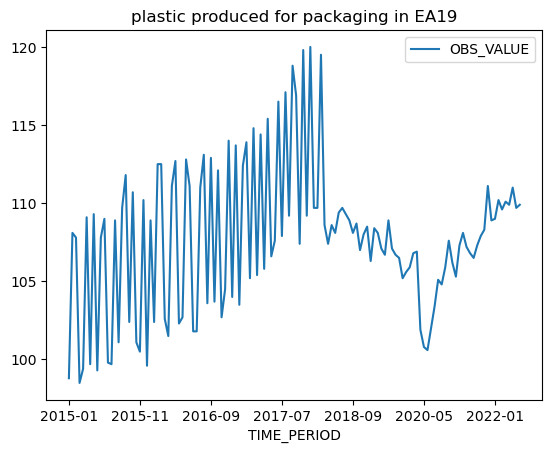

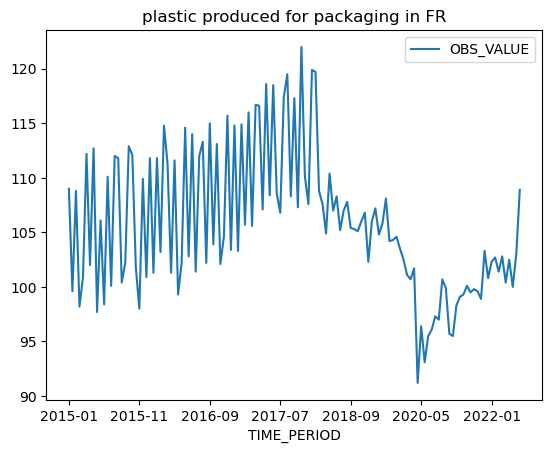

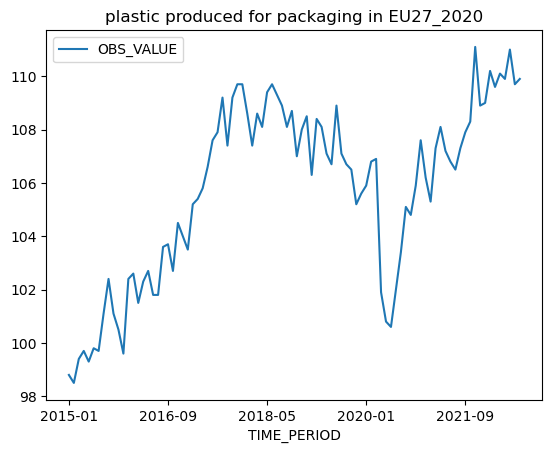

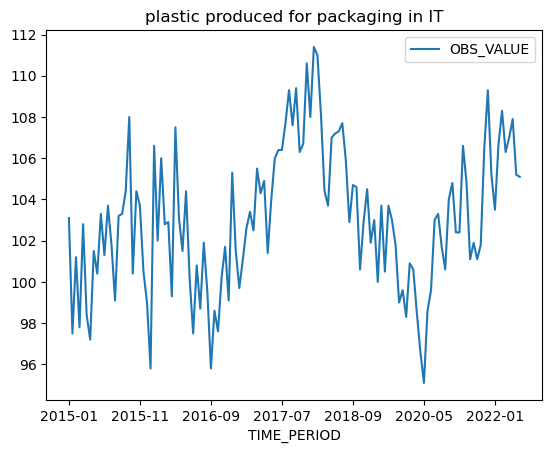

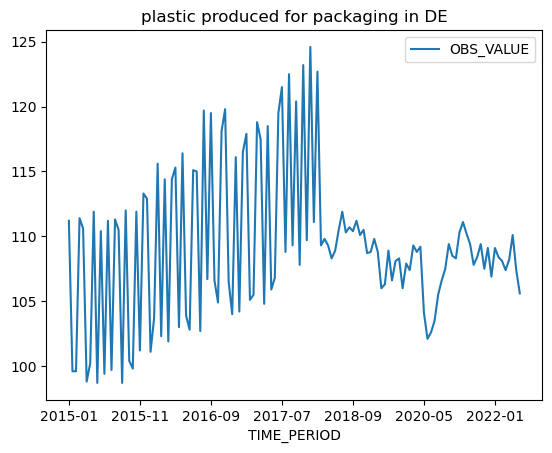

In [96]:
eu_nace_r2_c222 = eu_plastic_packaging[eu_plastic_packaging["nace_r2"] == "C2222"].sort_values("TIME_PERIOD")

for region in set(eu_nace_r2_c222["geo"]):
    df = eu_nace_r2_c222[eu_nace_r2_c222["geo"] == region]
    if len(df["OBS_VALUE"].dropna()) == 0:
        continue

    df.plot.line(
        x="TIME_PERIOD", y="OBS_VALUE", title="plastic produced for packaging in " +region, rot=0
    )

Notice the drop around 2020

In [97]:
new = eu_plastic_packaging[
    (eu_plastic_packaging["nace_r2"] == "C2222")
    & (eu_plastic_packaging["TIME_PERIOD"] >= "2020-01")
]
old = eu_plastic_packaging[
    (eu_plastic_packaging["nace_r2"] == "C2222")
    & (eu_plastic_packaging["TIME_PERIOD"] < "2020-01")
]

for each region we compare the production before and after covid to see how the pandemic affected the production

In [98]:
for region in set(
    eu_plastic_packaging[eu_plastic_packaging["nace_r2"] == "C2222"]["geo"]
):
    if region=='IE' or region=='UK' or region=='EU28': # we have no data for these 
        continue
    print(
        "difference in the mean ammount of plastic produced before and after covid in "+region,
        stats.ttest_ind(
            new[new["geo"] == region]["OBS_VALUE"].dropna(),
            old[old["geo"] == region]["OBS_VALUE"].dropna(),
        ),
    )

difference in the mean ammount of plastic produced before and after covid in TR Ttest_indResult(statistic=14.08859776353546, pvalue=1.729091479313658e-24)
difference in the mean ammount of plastic produced before and after covid in EL Ttest_indResult(statistic=11.450754284714431, pvalue=3.011158391140717e-21)
difference in the mean ammount of plastic produced before and after covid in ES Ttest_indResult(statistic=7.665508815722206, pvalue=4.028908308019724e-12)
difference in the mean ammount of plastic produced before and after covid in EA19 Ttest_indResult(statistic=-1.1226550361425272, pvalue=0.26371870915121226)
difference in the mean ammount of plastic produced before and after covid in FR Ttest_indResult(statistic=-7.84751909778192, pvalue=1.5225000977245244e-12)
difference in the mean ammount of plastic produced before and after covid in EU27_2020 Ttest_indResult(statistic=2.5313710264301355, pvalue=0.013097367301850515)
difference in the mean ammount of plastic produced before a

it seems for France and Germany the data shows a significant drop in production, while for spain Greece and turkey we see an increase

In [99]:
# Manufacture of plastics products by month by country
full_plastic_production = pd.read_csv(
    "Data/Additional/plastic/sts_inpr_m__custom_3857183_linear.csv"
)
# source: https://ec.europa.eu/eurostat/databrowser/view/STS_INPR_M__custom_3857183/default/table?lang=en

In [100]:
full_plastic_production = full_plastic_production[
    full_plastic_production["TIME_PERIOD"] >= "2018-01"
]

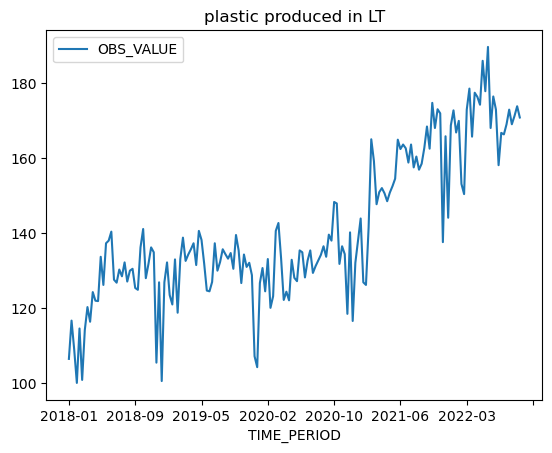

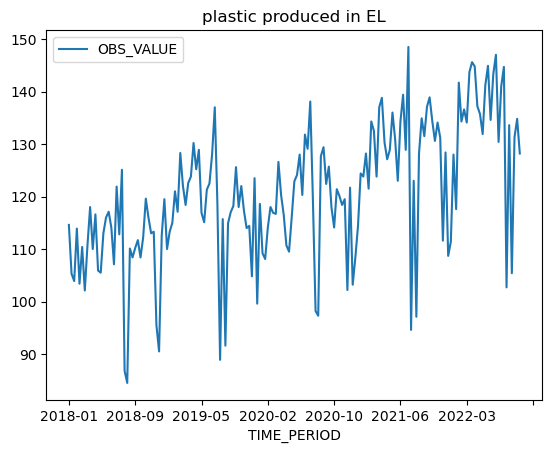

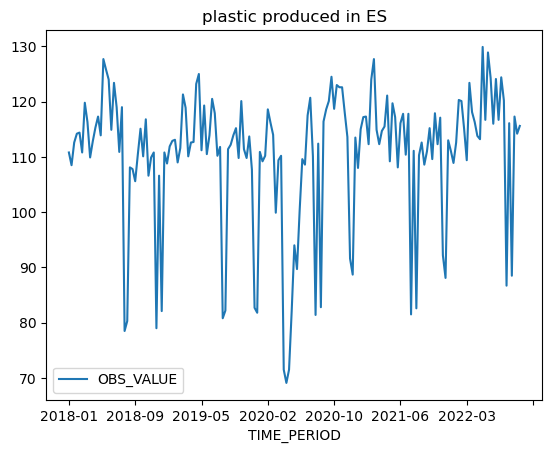

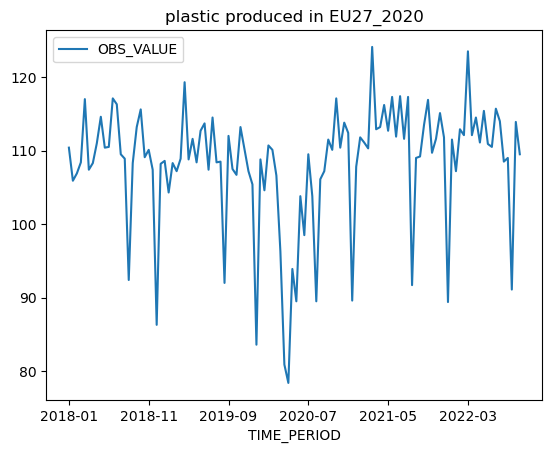

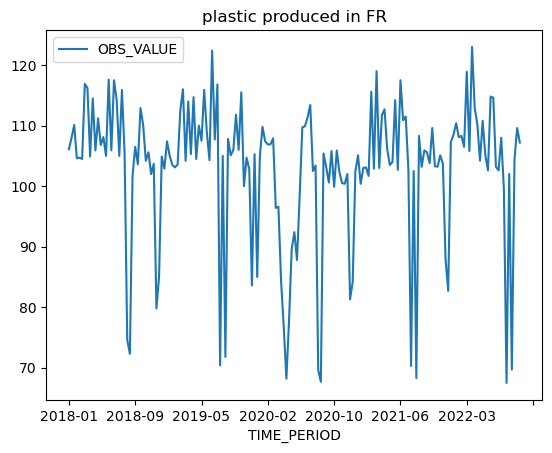

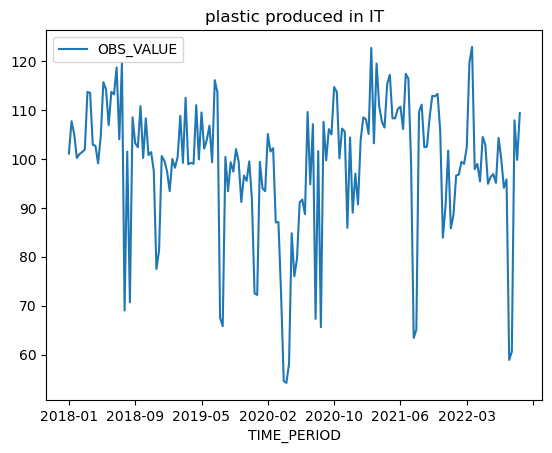

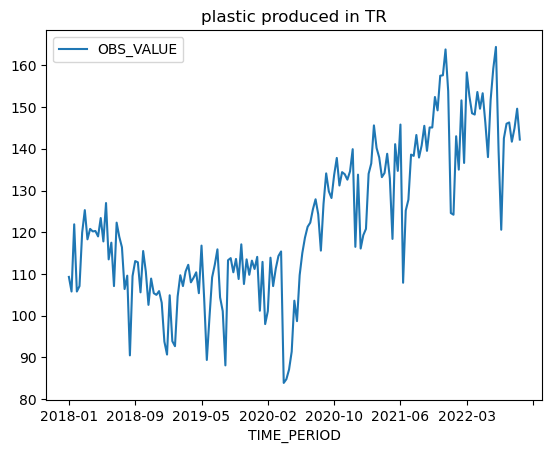

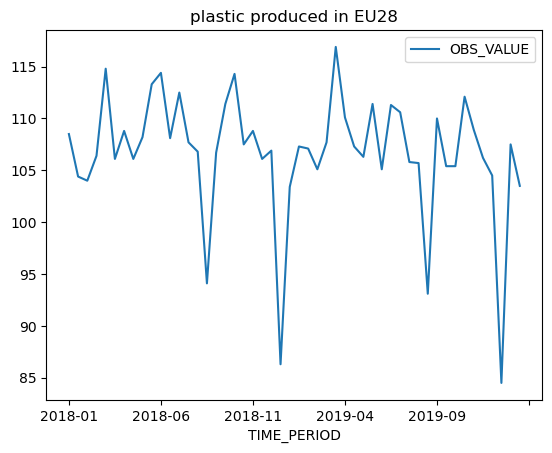

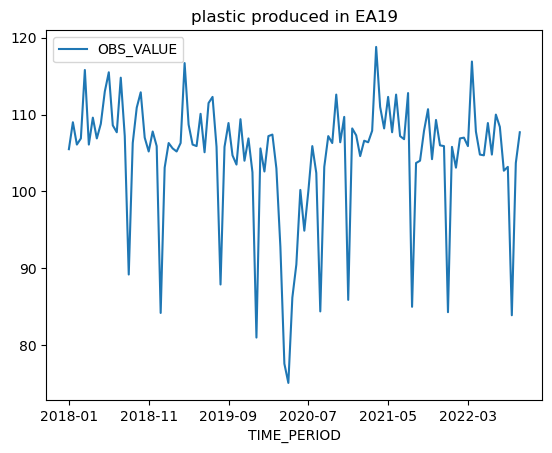

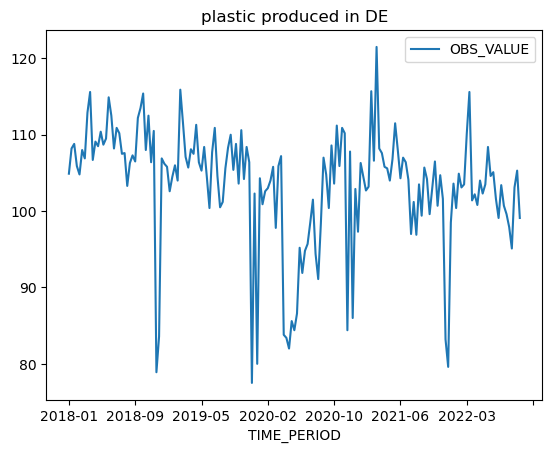

In [101]:
r2_c222 = full_plastic_production[full_plastic_production["nace_r2"] == "C222"].sort_values("TIME_PERIOD")
for region in set(r2_c222["geo"]):
    df = r2_c222[r2_c222["geo"] == region]
    if len(df["OBS_VALUE"].dropna()) == 0:
        continue

    df.plot.line(x="TIME_PERIOD", y="OBS_VALUE", title="plastic produced in " +region, rot=0)

notice how the drop during 2020 usually wider than the others and slightly deeper

## Study of the recycling rates and recovery rates
The goal here is to see how the recycling and recovery rates were affected by covid, since if we see a drop in plastic production it would be hard to state that it would lead to a drop in plastic pollution without studying first how covid impacted plastic management facilities.

source: https://ec.europa.eu/eurostat/databrowser/view/TEN00063__custom_3793752/default/table?lang=en

Recycling rates for packaging waste

In [102]:
Recycling_rates_eu = pd.read_csv(
    "Data/Additional/plastic/ten00063__custom_3793752_linear.csv"
)

In [103]:
# we filter for plastic waste
Recycling_rates_eu = Recycling_rates_eu[Recycling_rates_eu["waste"] == "W150102"]

In [104]:
stats.ttest_ind(
    Recycling_rates_eu[Recycling_rates_eu["TIME_PERIOD"] == 2020]["OBS_VALUE"],
    Recycling_rates_eu[Recycling_rates_eu["TIME_PERIOD"] == 2019]["OBS_VALUE"],
)

Ttest_indResult(statistic=-1.0725985166419096, pvalue=0.2888144167933384)

The data shows that the recycling rates are unaffected by covid, thus we can conclude that the recycling rates did not change from 2019 to 2020

Rate of recovery or incineration at waste incineration plants with energy recovery’ for the purposes of Article 6(1) of Directive 94/62/EC means the total quantity of packaging waste recovered or incinerated at waste incineration plants with energy recovery, divided by the total quantity of generated packaging waste https://ec.europa.eu/eurostat/databrowser/view/ten00062/default/table?lang=en

In [105]:
recovery_rates_eu = pd.read_csv("Data/Additional/plastic/ten00062_linear.csv")
recovery_rates_eu = recovery_rates_eu[recovery_rates_eu["waste"] == "W150102"]

In [106]:
stats.ttest_ind(
    recovery_rates_eu[recovery_rates_eu["TIME_PERIOD"] == 2020]["OBS_VALUE"],
    recovery_rates_eu[recovery_rates_eu["TIME_PERIOD"] == 2019]["OBS_VALUE"],
)

Ttest_indResult(statistic=0.08560441171826655, pvalue=0.932136971130831)

The data shows that the recovery rates are unaffected by covid, thus we can conclude that the recovery rates did not change from 2019 to 2020

## Study of the waste generated by households

In [107]:
eu_waste = pd.read_csv("Data/Additional/plastic/ten00110_linear.csv")
# https://ec.europa.eu/eurostat/databrowser/view/TEN00110/default/table?lang=en&category=env.env_was.env_wasgt

In [108]:
eu_waste = eu_waste[eu_waste["waste"] == "TOTAL"]

In [109]:
eu_waste[eu_waste["TIME_PERIOD"] == 2020]

,DATAFLOW,LAST UPDATE,freq,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
8,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,AT,2020,4630301,NaN
11,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,BA,2020,902567,NaN
20,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,BE,2020,5342390,NaN
29,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,BG,2020,2312155,NaN
38,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,CY,2020,378382,NaN
47,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,CZ,2020,6108373,NaN
56,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,DE,2020,38474001,NaN
65,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,DK,2020,3617933,NaN
74,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,EE,2020,550331,NaN
81,ESTAT:TEN00110(1.0),13/09/22 11:00:00,A,T,HAZ_NHAZ,EP_HH,TOTAL,EL,2020,4420481,p


[Text(0.5, 1.0, 'Household waste generated per year in the EU')]

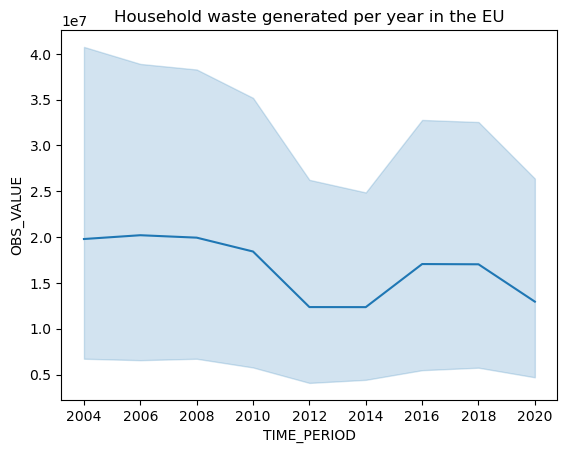

In [110]:
sns.lineplot(data=eu_waste, x="TIME_PERIOD", y="OBS_VALUE").set(title="Household waste generated per year in the EU")

We can see a drop of 0.5 in 2020, however, due to the low amount of data the confidence intervals are quite large, so it would be hard to perform statistical tests and get a meaningful result

## Study of the total amount of waste generated by households and businesses

In [111]:
eu_waste = pd.read_csv("Data/Additional/plastic/ten00108_linear.csv")
eu_waste = eu_waste[eu_waste["waste"] == "TOTAL"]
# https://ec.europa.eu/eurostat/databrowser/view/TEN00108/default/table?lang=en&category=env.env_was.env_wasgt

[Text(0.5, 1.0, 'Total amount of waste generated by the EU and buisnesses')]

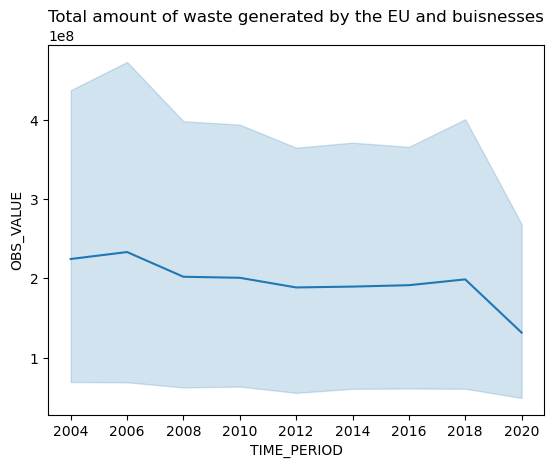

In [112]:
sns.lineplot(data=eu_waste, x="TIME_PERIOD", y="OBS_VALUE").set(title="Total amount of waste generated by the EU and buisnesses")

We can see a drop of almost 1 in 2020, however, due to the low amount of data the confidence intervals are quite large, so it would be hard to perform statistical tests and get a meaningful result

## Conclusion:
We saw that in some countries the plastic production experienced a significant decrease during covid, especially around 2020 we saw quite a drop probably due to lockdown. However, recycling rates and recovery rates did not experience significant change, More over The amount of waste generated decreased between 2018 and 2020 although one might question the validity of this due to a low amount of data.

Therefore with those results one might conclude that since less plastic was produced and with no impact on the recycling and recovery rates this might suggest that covid caused a drop plastic polution in the EU.


This analysis can be improved since one main issue is that the EU data lacks the data for some countries like Switzerland Poland and so on.
This causes some confidence intervals to inflate and thus makes some hypothesis hard to test.
We mainly focused on the EU and therefore we can improve it by adding other regions of the world.



## Step 3

The goal is to establish whether there is a link between awareness (i.e. Wikipedia views) and actual ground measurements about pollution. We will perform two experiments for each country : 
- **intervention analysis** : we find the peak of wikipedia views for a given wikipedia subject or page in 2020 (the peak of awareness, which we call the intervention) and check whether this peak translates to a significant change in empirical pollution. 
- **granger causality testing** : we test whether a given timeseries (wikipedia views) can be used to linearly predict the future of another timeseries (say, pollution). This gives us a hint about the temporal relationship between two observations.

First, we will perform intervention analysis. The first thing we need is to find the peaks of awareness in all fourteen countries in the environment dataset.

In [123]:
country_codes = sum_environment_df.language.unique()
peak2020 = {}
for code in country_codes:
    datapoints = sum_environment_df[sum_environment_df.language == code]
    datapoints = datapoints[datapoints.date.dt.year == 2020]
    peak = datapoints.environment_views.max()
    peakline = datapoints[datapoints.environment_views == peak].iloc[0]
    peak2020[code] = (peakline['environment_views'], peakline['date'])

In [124]:
peak2020

{'ja': (342857, Timestamp('2020-05-06 00:00:00')),
 'it': (270164, Timestamp('2020-04-22 00:00:00')),
 'da': (16062, Timestamp('2020-01-14 00:00:00')),
 'tr': (270470, Timestamp('2020-01-25 00:00:00')),
 'no': (36844, Timestamp('2020-01-08 00:00:00')),
 'en': (3065262, Timestamp('2020-01-13 00:00:00')),
 'sr': (42728, Timestamp('2020-04-24 00:00:00')),
 'sv': (52850, Timestamp('2020-02-09 00:00:00')),
 'nl': (105025, Timestamp('2020-02-09 00:00:00')),
 'de': (442831, Timestamp('2020-02-09 00:00:00')),
 'fr': (293466, Timestamp('2020-01-27 00:00:00')),
 'ca': (24632, Timestamp('2020-04-16 00:00:00')),
 'ko': (34645, Timestamp('2020-04-13 00:00:00')),
 'fi': (48049, Timestamp('2020-04-01 00:00:00'))}

Now that we have all peaks, we can look at the 365 previous days and the 365 following years in air pollution and analyze whether there is a significant difference in air quality. This will give us an idea of the relationship between awareness of environment problems 